In [1]:
import itertools
x = ['RELIANCE.NS', 'TATASTEEL.NS', 'HDFCBANK.NS', 'INFY.NS', 'BAJAJ-AUTO.NS', 'ICICIBANK.NS', 'ITC.NS',  'UPL.NS', 'ONGC.NS' , 'TITAN.NS', 'COALINDIA.NS', 'INDUSINDBK.NS', 'BAJAJFINSV.NS', 'GRASIM.NS', 'JSWSTEEL.NS','BBTC.NS',
    'ELGIRUBCO.NS','GNFC.NS','KEI.NS','BAJAJHLDNG.NS','GMRINFRA.NS','IGL.NS','VOLTAS.NS'] #'hindalco excluded
y = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'DOGE-USD', 'SOL1-USD', 'LTC-USD', 'BNB-USD', 'AVAX-USD', 'UNI3-USD', 'DOT1-USD', 'SUSHI-USD', 'LINK-USD', 'XRP-USD', 'ALGO-USD', 'EOS-USD', 'XTZ-USD', 'FIL-USD', 'ATOM1-USD', 'TRX-USD', 'MATIC-USD', 'CHZ-USD', 'FTT1-USD', 'NEAR-USD', 'SAND-USD', 'WAVES-USD', 'IOST-USD', 'DASH-USD', 'STORJ-USD', 'ZEC-USD', 'KSM-USD']
z = ['GC=F', 'SI=F', 'HG=F', 'PL=F', 'PA=F', 'CL=F', 'NG=F', 'RB=F', 'HO=F', 'BZ=F', 'KC=F', 'SB=F', 'CT=F', 'HE=F', 'LE=F', 'GOLD']

In [2]:
print(len(x),len(y),len(z))

23 30 16


In [ ]:
import datetime

In [ ]:
pip install newsapi-python


In [ ]:
pip install nltk


In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from newsapi import NewsApiClient


In [ ]:
newsapi = NewsApiClient(api_key='0b0d4a092c5442b48587125a198cf112')  # Replace with your NewsAPI key
nltk.download('vader_lexicon')  # Download the VADER lexicon for sentiment analysis
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def get_stock_news(stock_symbol, date):
    # Format the date to match the NewsAPI query format (YYYY-MM-DD)
    formatted_date = date.strftime('%Y-%m-%d')

    # Make a request to the NewsAPI for news articles related to the stock symbol and date
    response = newsapi.get_everything(q=stock_symbol, from_param=formatted_date, to=formatted_date, language='en')

    articles = response['articles']
    sentiment_scores = []

    for article in articles:
        # Analyze the sentiment of each news article's title
        title = article['title']
        sentiment_score = sia.polarity_scores(title)
        sentiment_scores.append(sentiment_score)

    return sentiment_scores


In [ ]:
def get_overall_sentiment(sentiment_scores):
    if not sentiment_scores:
        return 'No Sentiment'
    max_score = max(sentiment_scores, key=lambda score: score['compound'])

    if max_score['compound'] >= 0.05:
        return 1 #positive
    elif max_score['compound'] <= -0.05:
        return -1 #negative
    else:
        return 0 #neutral


In [ ]:
stock_symbol = 'AAPL'  # Replace with the desired stock symbol
date = datetime.date(2023, 6, 10)  # Replace with the desired date

sentiment_scores = get_stock_news(stock_symbol, date)

overall_sentiment = get_overall_sentiment(sentiment_scores)
print(f"Overall Sentiment: {overall_sentiment}")


Overall Sentiment: 1


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd

# # Download historical stock data for a specific ticker
# ticker = "AAPL"
# data = yf.download(ticker, start="2018-01-01", end="2023-05-10")

# Define functions to calculate technical indicators
def MACD(df, fast=12, slow=26, signal=9):
    exp1 = df["Close"].ewm(span=fast, adjust=False).mean()
    exp2 = df["Close"].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal

def ATR(df, n=14):
    high = df["High"]
    low = df["Low"]
    close = df["Close"]
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = true_range.rolling(n).mean()
    return atr

def normalized_ATR(df, n=14):
    atr = ATR(df, n)
    natr = atr / df["Close"] * 100
    return natr

def momentum(df, n=10):
    return df["Close"].diff(n)

def CO(df):
    adl = (2*df["Close"]-df["High"]-df["Low"])/(df["High"]-df["Low"])*df["Volume"]
    ema3 = adl.ewm(span=3, adjust=False).mean()
    ema10 = adl.ewm(span=10, adjust=False).mean()
    co = ema3 - ema10
    return co

def OBV(df):
    vol = df["Volume"]
    change = np.where(df["Close"].diff() > 0, 1, -1)
    obv = (vol * change).cumsum()
    return obv

# def MFI(df, n=14):
#     typical_price = (df["High"] + df["Low"] + df["Close"]) / 3
#     money_flow = typical_price * df["Volume"]
#     pos_flow = np.where(typical_price.diff() > 0, money_flow, 0)
#     neg_flow = np.where(typical_price.diff() < 0, money_flow, 0)
#     pos_mf = pos_flow.rolling(n).sum()
#     neg_mf = neg_flow.rolling(n).sum()
#     mf_ratio = pos_mf / neg_mf
#     mfi = 100 - (100 / (1 + mf_ratio))
#     return mfi
# def MFI(df, n=14):
#     # Calculate the typical price
#     typical_price = (df["High"] + df["Low"] + df["Close"]) / 3
#     # Calculate the raw money flow
#     raw_money_flow = typical_price * df["Volume"]
#     # Calculate the money flow ratio
#     positive_flow = np.where(typical_price > typical_price.shift(), raw_money_flow, 0)
#     negative_flow = np.where(typical_price < typical_price.shift(), raw_money_flow, 0)
#     positive_mf = pd.Series(positive_flow).rolling(window=n, min_periods=0).sum()
#     negative_mf = pd.Series(negative_flow).rolling(window=n, min_periods=0).sum()
#     money_flow_ratio = positive_mf / negative_mf
#     # Calculate the money flow index
#     money_flow_index = 100 - (100 / (1 + money_flow_ratio))
#     return money_flow_index


def MFI(df):
    # Calculate the Money Flow Index
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    raw_money_flow = typical_price * df['Volume']
    up_flow = np.where(typical_price > typical_price.shift(1), raw_money_flow, 0)
    down_flow = np.where(typical_price < typical_price.shift(1), raw_money_flow, 0)
    positive_money_flow = np.sum(up_flow)
    negative_money_flow = np.sum(down_flow)
    money_ratio = np.divide(positive_money_flow, negative_money_flow, where=negative_money_flow!=0)
    mfi = np.where(negative_money_flow==0, 100, 100 - (100 / (1 + money_ratio)))
    return mfi



# def HTDCP(df):
#     cycle, trend = pd.core.window.HammingWindow(window_len=11).frequency_response()*100
#     hilbert = pd.Series(pd.Series.rolling(df["Close"], window=31, center=True).apply(lambda x: np.abs(pd.Series(x).hilbert().real))).ewm(span=21, adjust=False).mean()
#     phase = np.degrees(np.arctan((hilbert - hilbert.shift(1)) / 0.0001))
#     dcp = ((phase.rolling(14).sum() / 14) - 90) * (-1)
#     return dcp
from scipy.signal import hilbert
from scipy.signal.windows import hamming

def HTDCP(df):
    # Calculate the Hilbert Transform Dominant Cycle Phase
    analytic_signal = hilbert(df["Close"])
    instantaneous_phase = np.degrees(np.unwrap(np.angle(analytic_signal)))
    hilbert_transform = np.abs(analytic_signal)
    hilbert_envelope = pd.Series(hilbert_transform).rolling(window=31, center=True, min_periods=1).mean()
    hilbert_smoothed = pd.Series(hilbert_envelope).rolling(window=11, center=True, min_periods=1).apply(lambda x: np.convolve(x, hamming(11), mode='same'), raw=True)
    hilbert_smoothed /= np.sum(hamming(11))
    hilbert_difference = np.abs(hilbert_smoothed.diff())
    hilbert_smoothed_numpy = np.asarray(hilbert_smoothed)  # convert to numpy array
    dcphase = np.degrees(np.unwrap(np.angle(pd.Series(hilbert_smoothed_numpy * np.exp(-1j * instantaneous_phase)).rolling(window=31, center=True).mean())))
    return dcphase




# def HTS(df, n=14):
#     # Extract the analytic signal using the Hilbert Transform
#     hilbert = pd.Series(pd.Series.rolling(df["Close"], window=31, center=True).apply(lambda x: pd.Series(x).hilbert()))
#     # Calculate the instantaneous amplitude and phase
#     inst_amplitude = np.abs(hilbert)
#     inst_phase = np.degrees(np.unwrap(np.angle(hilbert)))
#     # Calculate the sine wave
#     sinewave = np.sin(np.radians(inst_phase))
#     # Smooth the sine wave using an EMA
#     hts = pd.Series(sinewave).ewm(span=n, min_periods=n).mean()
#     return hts
from scipy.signal import hilbert

def HTS(df):
    # Calculate the Hilbert Transform Sinewave
    analytic_signal = hilbert(df['Close'])
    amplitude_envelope = np.abs(analytic_signal)
    instant_phase = np.unwrap(np.angle(analytic_signal))
    sinewave = np.sin(instant_phase)
    return sinewave


# def HTTMM(df):
#     # Calculate the Hilbert Transform Trend Market Mode
#     imf = pd.core.window.HammingWindow(window_len=11).frequency_response()*100
#     hilbert = pd.Series(pd.Series.rolling(df["Close"], window=31, center=True).apply(lambda x: np.abs(pd.Series(x).hilbert().real))).ewm(span=21, adjust=False).mean()
#     smoothed_imf = pd.Series(hilbert).ewm(span=14, adjust=False).mean()
#     trend = np.where(smoothed_imf > smoothed_imf.shift(), 1, -1)
#     return trend


# from scipy.signal import hilbert, chirp, find_peaks, peak_widths, welch, windows

# def HTTMM(df):
#     # Calculate the Hilbert Transform Trend Market Mode
#     instantaneous_phase = np.unwrap(np.angle(hilbert(df['Close'])))
#     inst_period = np.diff(instantaneous_phase)
#     inst_period = np.insert(inst_period, 0, inst_period[0])
#     inst_frequency = np.divide(1, inst_period)
#     frequency = welch(df['Close'], window='hamming', nperseg=len(df['Close']))[0]
#     peak_ind, _ = find_peaks(frequency, prominence=0.1)
#     widths = peak_widths(frequency, peak_ind, rel_height=0.5)
#     dominant_period = np.mean(widths[0] / len(frequency))
#     trend_market_mode = np.mod(np.divide(360, dominant_period) * instantaneous_phase, 360)
#     return trend_market_mode


from scipy.signal import hilbert, chirp, find_peaks, peak_widths, welch, windows

def HTTMM(df):
    if df.empty:
        return pd.Series()

    # Calculate the Hilbert Transform Trend Market Mode
    instantaneous_phase = np.unwrap(np.angle(hilbert(df['Close'])))
    inst_period = np.diff(instantaneous_phase)
    inst_period = np.insert(inst_period, 0, inst_period[0])
    inst_frequency = np.divide(1, inst_period)
    frequency = welch(df['Close'], window='hamming', nperseg=len(df['Close']))[0]
    peak_ind, _ = find_peaks(frequency, prominence=0.1)
    widths = peak_widths(frequency, peak_ind, rel_height=0.5)
    dominant_period = np.mean(widths[0] / len(frequency))
    trend_market_mode = np.mod(np.divide(360, dominant_period) * instantaneous_phase, 360)
    return trend_market_mode

# # Create a new dataframe to store the technical indicators
# features = pd.DataFrame(index=data.index)

# # Calculate the technical indicators
# features["macd"], features["signal"] = MACD(data)
# features["atr"] = ATR(data)
# features["natr"] = normalized_ATR(data)
# features["momentum"] = momentum(data)
# features["co"] = CO(data)
# features["obv"] = OBV(data)
# features["mfi"] = MFI(data)
# features["dcp"] = HTDCP(data)
# features["hts"] = HTS(data)
# features["httmm"] = HTTMM(data)

# # Print the resulting dataframe
# print(features.head())


try to extract using time

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta

# Define the stock symbols you want to fetch data for
stock_symbols = x # Add more symbols if needed

# Define the start and end dates for the data retrieval
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=498)).strftime('%Y-%m-%d')

# Define the desired time for data retrieval
time_of_day = ['10:00:00', '11:00:00']
time_of_day_end=['15:00:00','16:00:00']
# Initialize an empty dictionary to store the data
stock_data = {}

# Iterate over each stock symbol
for symbol in stock_symbols:
    # Fetch the historical data for the given stock symbol
    stock = yf.download(symbol, period='2y', interval='1h')
    # temp=yf.download(symbol,start_date=datetime(2021,10,18))
    # print(temp)
    # Filter the data for the desired time of day
    filtered_data_start = stock.between_time(*time_of_day)
    filtered_data_end=stock.between_time(*time_of_day_end)

    # Store the filtered data in the dictionary
    # print(filtered_data_start)
    # print(filtered_data_end)
    df_stock=pd.DataFrame()
    s_2=yf.download(symbol,period='2y',interval='1d')
    s_2.index=s_2.index.date
    # print(filtered_data_end['Close'])
    print(symbol)
    filtered_data_start.index=filtered_data_start.index.date
    filtered_data_end.index=filtered_data_end.index.date

    a=set(filtered_data_start.index)
    b=set(filtered_data_end.index)
    print(b-a)
    df_stock['Close']=filtered_data_end['Close']
    df_stock['Open']=filtered_data_start['Open']
    df_stock['High']=s_2['High']
    print(len(filtered_data_start))
    print(len(filtered_data_end))
    print(len(s_2))
    print(df_stock)
    print(s_2)
    stock_data[symbol]=df_stock


# Accessing the data for a specific stock symbol
# print(stock_data)

# print(len(stock_data['']))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
RELIANCE.NS
{datetime.date(2021, 10, 18)}
492
493
497
                  Close         Open         High
2021-06-30  2112.000000  2099.750000  2122.649902
2021-07-01  2099.949951  2115.000000  2123.149902
2021-07-02  2131.550049  2116.500000  2132.899902
2021-07-05  2149.699951  2141.399902  2153.550049
2021-07-06  2127.850098  2137.050049  2148.899902
...                 ...          ...          ...
2023-06-21  2564.899902  2568.600098  2569.850098
2023-06-22  2539.000000  2569.750000  2573.300049
2023-06-23  2514.750000  2521.250000  2533.399902
2023-06-26  2496.000000  2503.199951  2515.399902
2023-06-27  2496.449951  2496.199951  2509.500000

[493 rows x 3 columns]
                   Open         High          Low        Close    Adj Close  \
2021-06-29  2089.500000  2109.000000  2084.100098  2087.800049  2081.533203   
2021-06-30  2096.250000  2

In [ ]:
date="2023-06-27"
end_date="2023-06-29"
stock_data = yf.download('RELIANCE.NS', period='1d',interval='1h')
# import matplotlib.pyplot as plt
# plt.plot(stock_data['Open'])
print(stock_data)

[*********************100%***********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RELIANCE.NS']: Exception('%ticker%: No price data found, symbol may be delisted (period=1d)')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


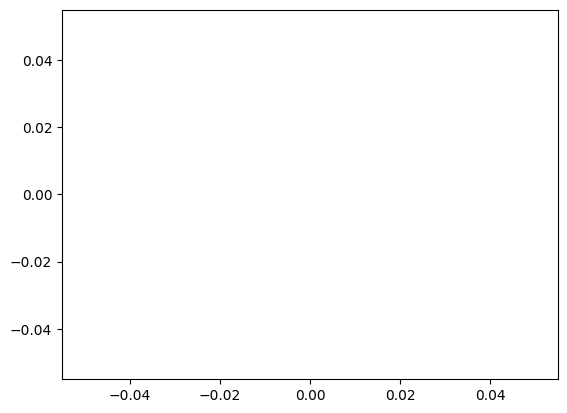

In [ ]:
import matplotlib.pyplot as plt
plt.plot(stock_data['Open'])

In [ ]:
print(s_2)

                   Open         High          Low        Close    Adj Close  \
2021-06-29  1048.000000  1051.500000   984.349976  1028.400024  1001.829956   
2021-06-30  1033.000000  1035.900024  1015.549988  1022.450012   996.033630   
2021-07-01  1024.000000  1025.400024  1012.000000  1013.000000   986.827881   
2021-07-02  1017.000000  1017.000000   997.200012  1013.900024   987.704590   
2021-07-05  1018.200012  1024.449951  1012.799988  1014.599976   988.386414   
...                 ...          ...          ...          ...          ...   
2023-06-22   786.000000   789.000000   778.549988   782.099976   782.099976   
2023-06-23   768.200012   777.500000   748.500000   750.500000   750.500000   
2023-06-26   753.150024   759.000000   747.599976   757.650024   757.650024   
2023-06-27   760.900024   767.799988   757.900024   761.099976   761.099976   
2023-06-28   763.000000   766.700012   758.799988   766.000000   766.000000   

             Volume  
2021-06-29  2482160  
2021-06

**continue actual code**

In [ ]:

import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# Define the tickers and number of y in the portfolio
# tickers = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'INFY.NS', 'ITC.NS', 'KOTAKBANK.NS', 'BAJFINANCE.NS', 'HDFC.NS', 'BSESN.BO', 'BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD', 'ADA-USD', 'GC=F', 'SI=F', 'CL=F', 'NG=F', 'PL=F']
# stocks = list(itertools.chain(x,y,z))
# # # ys=x
# # crypto=y
# # commod=z
# n_y = len(y)
data_stock = {}
data_crypto={}
data_commodity={}
x_excluded=[]
time_of_day = ['10:00:00', '11:00:00']
time_of_day_end=['14:00:00','15:00:00']
for stock in x:
    s = yf.download(stock, period='2y', interval='1h')

    # Filter the data for the desired time of day
    filtered_data_start = s.between_time(*time_of_day)
    filtered_data_end=s.between_time(*time_of_day_end)
    # Store the filtered data in the dictionary
    # print(filtered_data_start)
    # print(filtered_data_end)
    df_stock=pd.DataFrame()
    # print(filtered_data_end['Close'])
    filtered_data_start.index=filtered_data_start.index.date
    filtered_data_end.index=filtered_data_end.index.date
    print(len(filtered_data_start))
    print(len(filtered_data_end))
    print(stock)

    s_2=yf.download(stock,period='2y',interval='1d')
    s_2.index=s_2.index.date


    df_stock['Close']=filtered_data_end['Close']
    df_stock['Open']=filtered_data_start['Open']
    df_stock['High']=s_2['High']
    df_stock['Low']=s_2['Low']
    df_stock['Volume']=s_2['Volume']

    df_stock['Open'].fillna(df_stock['Open'].rolling(3, min_periods=1, center=True).mean(), inplace=True)
    df_stock['Close'].fillna(df_stock['Close'].rolling(3, min_periods=1, center=True).mean(), inplace=True)
    df_stock['High'].fillna(df_stock['High'].rolling(3, min_periods=1, center=True).mean(), inplace=True)
    df_stock['Low'].fillna(df_stock['Low'].rolling(3, min_periods=1, center=True).mean(), inplace=True)
    df_stock['Volume'].fillna(df_stock['Volume'].rolling(3, min_periods=1, center=True).mean(), inplace=True)
    data_stock[stock]=df_stock


    # data_stock[stock] = yf.download(stock, period='2y',interval='1d')
# rate of return over 2 days

filtered_x = [stock for stock in x if stock not in x_excluded]
for stock in filtered_x:
    data_stock[stock]['return_2d'] = (data_stock[stock]['Close'] / data_stock[stock]['Open']) - 1

# data[stock]['return_2d'] = (data[stock]['Close'] / data[stock]['Close'].shift(2)) - 1
    #new
for stock in filtered_x:
    data_stock[stock]['macd'], data_stock[stock]['signal'] = MACD(data_stock[stock])

for stock in filtered_x:
    print(stock)
    data_stock[stock]["atr"] = ATR(data_stock[stock])

    data_stock[stock]["natr"] = normalized_ATR(data_stock[stock])
    data_stock[stock]["momentum"] = momentum(data_stock[stock])
    data_stock[stock]["co"] = CO(data_stock[stock])
    data_stock[stock]["obv"] = OBV(data_stock[stock])
    data_stock[stock]["mfi"] = MFI(data_stock[stock])
    # data_stock[stock]["dcp"] = HTDCP(data_stock[stock])
    data_stock[stock]["hts"] = HTS(data_stock[stock])
    # data_stock[stock]["httmm"] = HTTMM(data_stock[stock])

# movig avg 10 and 5 days
for stock in filtered_x:
  data_stock[stock]['ma_10d'] = data_stock[stock]['Close'].rolling(window=10, min_periods=1).mean()
  data_stock[stock]['ma_5d'] = data_stock[stock]['Close'].rolling(window=5, min_periods=1).mean()

# volatility
for stock in filtered_x:
  data_stock[stock]['volatility'] = np.log(data_stock[stock]['Close'] / data_stock[stock]['Close'].shift(1)).rolling(window=10).std() * np.sqrt(252)
# volume
for stock in filtered_x:
  data_stock[stock]['volume'] = data_stock[stock]['Volume']
# rsi
for stock in filtered_x:
  delta = data_stock[stock]['Close'].diff()
  gain = delta.where(delta > 0, 0)
  loss = -delta.where(delta < 0, 0)
  avg_gain = gain.rolling(window=14, min_periods=1).mean()
  avg_loss = loss.rolling(window=14, min_periods=1).mean()
  rs = avg_gain / avg_loss
  data_stock[stock]['rsi'] = 100 - (100 / (1 + rs))

# psychological index
for stock in filtered_x:
  n = 14
  data_stock[stock]['up_days'] = data_stock[stock]['Close'] > data_stock[stock]['Close'].shift(1)
  data_stock[stock]['Nup'] = data_stock[stock]['up_days'].rolling(window=n).sum()
  data_stock[stock]['N'] = n
  data_stock[stock]['psychological_index'] = data_stock[stock]['Nup'] / data_stock[stock]['N']
for stock in filtered_x:
  data_stock[stock]['return_prev_day'] = data_stock[stock]['return_2d'].shift(1)
  data_stock[stock]['return_prev_week'] = data_stock[stock]['return_2d'].shift(7)
  data_stock[stock]['return_prev_fortnight'] = data_stock[stock]['return_2d'].shift(15)

for stock in filtered_x:
  # nifty_data = yf.download('^NSEI', start=data_stock[stock]['Date'], end=data_stock[stock]['Date'])
  # df=pd.DataFrame(nifty_data)
  # if(len(df)==0):
  #   data_stock[stock]['nifty'] = 0

  # else:
  #   data_stock[stock]['nifty'] = df['Open'][0]
  data_stock[stock]['nifty'] = pd.DataFrame(yf.download('^NSEI', period='2y',interval='1d'))['Open']
  data_stock[stock]['sensex'] = pd.DataFrame(yf.download('^BSESN', period='2y',interval='1d'))['Open']
  data_stock[stock]['nifty_bank'] = pd.DataFrame(yf.download('^NSEBANK', period='2y',interval='1d'))['Open']
  data_stock[stock]['nifty_it'] = pd.DataFrame(yf.download('^CNXIT', period='2y',interval='1d'))['Open']


# for stock in x:
#   sentiment_scores = get_stock_news(stock, date)
#   data_stock[stock]['sentiment'] =
#concatenate
df_stock_f = pd.concat(data_stock, keys=filtered_x)



[*********************100%***********************]  1 of 1 completed
492
493
RELIANCE.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
492
493
TATASTEEL.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
492
493
HDFCBANK.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
492
493
INFY.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
492
493
BAJAJ-AUTO.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
492
493
ICICIBANK.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  

In [ ]:
df_stock_f

Close         Open         High          Low  \
RELIANCE.NS 2021-06-30  2111.750000  2099.750000  2122.649902  2091.050049   
            2021-07-01  2096.100098  2115.000000  2123.149902  2095.000000   
            2021-07-02  2129.750000  2116.500000  2132.899902  2092.949951   
            2021-07-05  2148.800049  2141.399902  2153.550049  2131.500000   
            2021-07-06  2122.899902  2137.050049  2148.899902  2120.199951   
...                             ...          ...          ...          ...   
VOLTAS.NS   2023-06-21   791.000000   793.099976   794.000000   783.000000   
            2023-06-22   782.049988   786.000000   789.000000   778.549988   
            2023-06-23   751.299988   752.000000   777.500000   748.500000   
            2023-06-26   758.049988   755.250000   759.000000   747.599976   
            2023-06-27   761.599976   762.799988   767.799988   757.900024   

                         Volume  return_2d       macd    signal        atr  \
RELIANCE.NS 2021-06-30  9120556   0.005715   0.000000  0.000000        NaN   
            2021-07-01  5784627  -0.008936  -1.248425 -0.249685        NaN   
            2021-07-02  6500973   0.006260   0.472014 -0.105345        NaN   
            2021-07-05  5400604   0.003456   3.334219  0.582567        NaN   
            2021-07-06  4647361  -0.006621   3.472582  1.160570        NaN   
...                         ...        ...        ...       ...        ...   
VOLTAS.NS   2023-06-21  1583443  -0.002648  -6.146638 -4.790109  16.357147   
            2023-06-22  1942087  -0.005025  -7.014265 -5.234940  16.264291   
            2023-06-23  4692817  -0.000931 -10.067087 -6.201370  18.196433   
            2023-06-26  1236917   0.003707 -11.805713 -7.322238  16.610722   
            2023-06-27  1446118  -0.001573 -12.750156 -8.407822  16.757150   

                            natr  ...  Nup   N  psychological_index  \
RELIANCE.NS 2021-06-30       NaN  ...  NaN  14                  NaN   
            2021-07-01       NaN  ...  NaN  14                  NaN   
            2021-07-02       NaN  ...  NaN  14                  NaN   
            2021-07-05       NaN  ...  NaN  14                  NaN   
            2021-07-06       NaN  ...  NaN  14                  NaN   
...                          ...  ...  ...  ..                  ...   
VOLTAS.NS   2023-06-21  2.067907  ...  6.0  14             0.428571   
            2023-06-22  2.079700  ...  6.0  14             0.428571   
            2023-06-23  2.421993  ...  5.0  14             0.357143   
            2023-06-26  2.191244  ...  6.0  14             0.428571   
            2023-06-27  2.200256  ...  6.0  14             0.428571   

                        return_prev_day  return_prev_week  \
RELIANCE.NS 2021-06-30              NaN               NaN   
            2021-07-01         0.005715               NaN   
            2021-07-02        -0.008936               NaN   
            2021-07-05         0.006260               NaN   
            2021-07-06         0.003456               NaN   
...                                 ...               ...   
VOLTAS.NS   2023-06-21        -0.003159          0.007722   
            2023-06-22        -0.002648          0.010579   
            2023-06-23        -0.005025          0.011918   
            2023-06-26        -0.000931         -0.008712   
            2023-06-27         0.003707          0.000566   

                        return_prev_fortnight         nifty        sensex  \
RELIANCE.NS 2021-06-30                    NaN  15776.900391  52651.089844   
            2021-07-01                    NaN  15755.049805  52638.500000   
            2021-07-02                    NaN  15705.849609  52434.550781   
            2021-07-05                    NaN  15793.400391  52682.890625   
            2021-07-06                    NaN  15813.750000  52874.851562   
...                                       ...           ...           ...   
VOLTAS.NS   2023-06-21         

In [ ]:
df_stock=df_stock_f

In [ ]:
df_stock

Close         Open         High          Low  \
RELIANCE.NS 2021-06-30  2111.750000  2099.750000  2122.649902  2091.050049   
            2021-07-01  2096.100098  2115.000000  2123.149902  2095.000000   
            2021-07-02  2129.750000  2116.500000  2132.899902  2092.949951   
            2021-07-05  2148.800049  2141.399902  2153.550049  2131.500000   
            2021-07-06  2122.899902  2137.050049  2148.899902  2120.199951   
...                             ...          ...          ...          ...   
VOLTAS.NS   2023-06-21   791.000000   793.099976   794.000000   783.000000   
            2023-06-22   782.049988   786.000000   789.000000   778.549988   
            2023-06-23   751.299988   752.000000   777.500000   748.500000   
            2023-06-26   758.049988   755.250000   759.000000   747.599976   
            2023-06-27   761.599976   762.799988   767.799988   757.900024   

                         Volume  return_2d       macd    signal        atr  \
RELIANCE.NS 2021-06-30  9120556   0.005715   0.000000  0.000000        NaN   
            2021-07-01  5784627  -0.008936  -1.248425 -0.249685        NaN   
            2021-07-02  6500973   0.006260   0.472014 -0.105345        NaN   
            2021-07-05  5400604   0.003456   3.334219  0.582567        NaN   
            2021-07-06  4647361  -0.006621   3.472582  1.160570        NaN   
...                         ...        ...        ...       ...        ...   
VOLTAS.NS   2023-06-21  1583443  -0.002648  -6.146638 -4.790109  16.357147   
            2023-06-22  1942087  -0.005025  -7.014265 -5.234940  16.264291   
            2023-06-23  4692817  -0.000931 -10.067087 -6.201370  18.196433   
            2023-06-26  1236917   0.003707 -11.805713 -7.322238  16.610722   
            2023-06-27  1446118  -0.001573 -12.750156 -8.407822  16.757150   

                            natr  ...  Nup   N  psychological_index  \
RELIANCE.NS 2021-06-30       NaN  ...  NaN  14                  NaN   
            2021-07-01       NaN  ...  NaN  14                  NaN   
            2021-07-02       NaN  ...  NaN  14                  NaN   
            2021-07-05       NaN  ...  NaN  14                  NaN   
            2021-07-06       NaN  ...  NaN  14                  NaN   
...                          ...  ...  ...  ..                  ...   
VOLTAS.NS   2023-06-21  2.067907  ...  6.0  14             0.428571   
            2023-06-22  2.079700  ...  6.0  14             0.428571   
            2023-06-23  2.421993  ...  5.0  14             0.357143   
            2023-06-26  2.191244  ...  6.0  14             0.428571   
            2023-06-27  2.200256  ...  6.0  14             0.428571   

                        return_prev_day  return_prev_week  \
RELIANCE.NS 2021-06-30              NaN               NaN   
            2021-07-01         0.005715               NaN   
            2021-07-02        -0.008936               NaN   
            2021-07-05         0.006260               NaN   
            2021-07-06         0.003456               NaN   
...                                 ...               ...   
VOLTAS.NS   2023-06-21        -0.003159          0.007722   
            2023-06-22        -0.002648          0.010579   
            2023-06-23        -0.005025          0.011918   
            2023-06-26        -0.000931         -0.008712   
            2023-06-27         0.003707          0.000566   

                        return_prev_fortnight         nifty        sensex  \
RELIANCE.NS 2021-06-30                    NaN  15776.900391  52651.089844   
            2021-07-01                    NaN  15755.049805  52638.500000   
            2021-07-02                    NaN  15705.849609  52434.550781   
            2021-07-05                    NaN  15793.400391  52682.890625   
            2021-07-06                    NaN  15813.750000  52874.851562   
...                                       ...           ...           ...   
VOLTAS.NS   2023-06-21         

In [ ]:
df_stock.shape

(11339, 31)

In [ ]:
for r in x:
  print(df_stock.loc[r].shape)

(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)
(493, 31)


In [ ]:
# for stock in y:
#     data_crypto[stock] = yf.download(stock, period='2y',interval='1d')
# # rate of return over 2 days
# for stock in y:
#     data_crypto[stock]['return_2d'] = (data_crypto[stock]['Close'] / data_crypto[stock]['Open']) - 1


#     #new
# for stock in y:
#     data_crypto[stock]['macd'], data_crypto[stock]['signal'] = MACD(data_crypto[stock])

# for stock in y:
#     data_crypto[stock]["atr"] = ATR(data_crypto[stock])

#     data_crypto[stock]["natr"] = normalized_ATR(data_crypto[stock])
#     data_crypto[stock]["momentum"] = momentum(data_crypto[stock])
#     data_crypto[stock]["co"] = CO(data_crypto[stock])
#     data_crypto[stock]["obv"] = OBV(data_crypto[stock])
#     data_crypto[stock]["mfi"] = MFI(data_crypto[stock])
#     # data_crypto[stock]["dcp"] = HTDCP(data_crypto[stock])
#     data_crypto[stock]["hts"] = HTS(data_crypto[stock])
#     # data_crypto[stock]["httmm"] = HTTMM(data_crypto[stock])

# # movig avg 10 and 5 days
# for stock in y:
#   data_crypto[stock]['ma_10d'] = data_crypto[stock]['Close'].rolling(window=10, min_periods=1).mean()
#   data_crypto[stock]['ma_5d'] = data_crypto[stock]['Close'].rolling(window=5, min_periods=1).mean()

# # volatility
# for stock in y:
#   data_crypto[stock]['volatility'] = np.log(data_crypto[stock]['Close'] / data_crypto[stock]['Close'].shift(1)).rolling(window=10).std() * np.sqrt(252)
# # volume
# for stock in y:
#   data_crypto[stock]['volume'] = data_crypto[stock]['Volume']
# # rsi
# for stock in y:
#   delta = data_crypto[stock]['Close'].diff()
#   gain = delta.where(delta > 0, 0)
#   loss = -delta.where(delta < 0, 0)
#   avg_gain = gain.rolling(window=14, min_periods=1).mean()
#   avg_loss = loss.rolling(window=14, min_periods=1).mean()
#   rs = avg_gain / avg_loss
#   data_crypto[stock]['rsi'] = 100 - (100 / (1 + rs))

# # psychological index
# for stock in y:
#   n = 14
#   data_crypto[stock]['up_days'] = data_crypto[stock]['Close'] > data_crypto[stock]['Close'].shift(1)
#   data_crypto[stock]['Nup'] = data_crypto[stock]['up_days'].rolling(window=n).sum()
#   data_crypto[stock]['N'] = n
#   data_crypto[stock]['psychological_index'] = data_crypto[stock]['Nup'] / data_crypto[stock]['N']
# for stock in y:
#   data_crypto[stock]['return_prev_day'] = data_crypto[stock]['return_2d'].shift(1)
#   data_crypto[stock]['return_prev_week'] = data_crypto[stock]['return_2d'].shift(7)
#   data_crypto[stock]['return_prev_fortnight'] = data_crypto[stock]['return_2d'].shift(15)
# #concatenate
# df_crypto = pd.concat(data_crypto, keys=y)


In [ ]:
# df_crypto

In [ ]:
# for r in y:
#   print(r,df_crypto.loc[r].shape)

In [ ]:
# data_commodity={}
# for stock in z:
#     data_commodity[stock] = yf.download(stock, period='2y',interval='1d')
# # rate of return over 1 days
# for stock in z:
#     data_commodity[stock]['return_2d'] = (data_commodity[stock]['Close'] / data_commodity[stock]['Open']) - 1


#     #new
# for stock in z:
#     data_commodity[stock]['macd'], data_commodity[stock]['signal'] = MACD(data_commodity[stock])

# for stock in z:
#     data_commodity[stock]["atr"] = ATR(data_commodity[stock])

#     data_commodity[stock]["natr"] = normalized_ATR(data_commodity[stock])
#     data_commodity[stock]["momentum"] = momentum(data_commodity[stock])
#     data_commodity[stock]["co"] = CO(data_commodity[stock])
#     data_commodity[stock]["obv"] = OBV(data_commodity[stock])
#     data_commodity[stock]["mfi"] = MFI(data_commodity[stock])
#     # data_commodity[stock]["dcp"] = HTDCP(data_commodity[stock])
#     data_commodity[stock]["hts"] = HTS(data_commodity[stock])
#     # data_commodity[stock]["httmm"] = HTTMM(data_commodity[stock])

# # movig avg 10 and 5 days
# for stock in z:
#   data_commodity[stock]['ma_10d'] = data_commodity[stock]['Close'].rolling(window=10, min_periods=1).mean()
#   data_commodity[stock]['ma_5d'] = data_commodity[stock]['Close'].rolling(window=5, min_periods=1).mean()

# # volatility
# for stock in z:
#   data_commodity[stock]['volatility'] = np.log(data_commodity[stock]['Close'] / data_commodity[stock]['Close'].shift(1)).rolling(window=10).std() * np.sqrt(252)
# # volume
# for stock in z:
#   data_commodity[stock]['volume'] = data_commodity[stock]['Volume']
# # rsi
# for stock in z:
#   delta = data_commodity[stock]['Close'].diff()
#   gain = delta.where(delta > 0, 0)
#   loss = -delta.where(delta < 0, 0)
#   avg_gain = gain.rolling(window=14, min_periods=1).mean()
#   avg_loss = loss.rolling(window=14, min_periods=1).mean()
#   rs = avg_gain / avg_loss
#   data_commodity[stock]['rsi'] = 100 - (100 / (1 + rs))

# # psychological index
# for stock in z:
#   n = 14
#   data_commodity[stock]['up_days'] = data_commodity[stock]['Close'] > data_commodity[stock]['Close'].shift(1)
#   data_commodity[stock]['Nup'] = data_commodity[stock]['up_days'].rolling(window=n).sum()
#   data_commodity[stock]['N'] = n
#   data_commodity[stock]['psychological_index'] = data_commodity[stock]['Nup'] / data_commodity[stock]['N']
# for stock in z:
#   data_commodity[stock]['return_prev_day'] = data_commodity[stock]['return_2d'].shift(1)
#   data_commodity[stock]['return_prev_week'] = data_commodity[stock]['return_2d'].shift(7)
#   data_commodity[stock]['return_prev_fortnight'] = data_commodity[stock]['return_2d'].shift(15)
# for stock in z:
#   # nifty_data = yf.download('^NSEI', start=data_stock[stock]['Date'], end=data_stock[stock]['Date'])
#   # df=pd.DataFrame(nifty_data)
#   # if(len(df)==0):
#   #   data_stock[stock]['nifty'] = 0

#   # else:
#   #   data_stock[stock]['nifty'] = df['Open'][0]
#   # data_commodity[stock]['nifty'] = pd.DataFrame(yf.download('^NSEI', period='2y',interval='1d'))['Open']
#   data_commodity[stock]['nifty'] = pd.DataFrame(yf.download('^NSEI', period='2y',interval='1d'))['Open']
#   data_commodity[stock]['sensex'] = pd.DataFrame(yf.download('^BSESN', period='2y',interval='1d'))['Open']
#   data_commodity[stock]['nifty_bank'] = pd.DataFrame(yf.download('^NSEBANK', period='2y',interval='1d'))['Open']
#   data_commodity[stock]['nifty_it'] = pd.DataFrame(yf.download('^CNXIT', period='2y',interval='1d'))['Open']

# #concatenate
# df_commodity = pd.concat(data_commodity, keys=z)


In [ ]:
# for r in z:
#   print(r,df_commodity.loc[r].shape)

In [ ]:
# df_commodity.columns

In [ ]:
# df_filled_stock = df_stock.groupby(level=0).apply(lambda x: x.fillna(x.mean()))
df_filled_stock=df_stock.fillna(df_stock.mean())
has_null = df_filled_stock.isnull().any().any()

# Print the result
if has_null:
    print("DataFrame still has null values.")
else:
    print("DataFrame does not have any null values.")
# df_filled_stock = df_filled_stock.fillna(0)
features = ['return_2d', 'ma_10d', 'ma_5d', 'volatility', 'rsi', 'volume','return_prev_day','return_prev_week','return_prev_fortnight','psychological_index','atr','momentum','co','obv','mfi','hts']
#features = ['return_2d']
# df_filled_crypto = df_crypto.groupby(level=0).apply(lambda x: x.fillna(x.mean()))
# df_filled_crypto = df_filled_crypto.fillna(0)
# features = ['return_2d', 'ma_10d', 'ma_5d', 'volatility', 'rsi', 'volume','return_prev_day','return_prev_week','return_prev_fortnight','psychological_index','atr','momentum','co','obv','mfi','hts']
#features = ['return_2d']
# df_filled_commodity = df_commodity.groupby(level=0).apply(lambda x: x.fillna(x.mean()))
# df_filled_commodity = df_filled_commodity.fillna(0)
# features = ['return_2d', 'ma_10d', 'ma_5d', 'volatility', 'rsi', 'volume','return_prev_day','return_prev_week','return_prev_fortnight','psychological_index','atr','momentum','co','obv','mfi','hts']
#features = ['return_2d']

DataFrame does not have any null values.


In [ ]:
has_zero = (df_filled_stock['Open'] == 0).any()
if has_zero:
    print("DataFrame still has zero values.")
else:
    print("DataFrame does not have any zero values.")

DataFrame does not have any zero values.


In [ ]:
has_zero = (df_filled_stock['Close'] == 0).any()
if has_zero:
    print("DataFrame still has zero values.")
else:
    print("DataFrame does not have any zero values.")

DataFrame does not have any zero values.


In [ ]:
has_zero = (df_filled_stock['High'] == 0).any()
if has_zero:
    print("DataFrame still has zero values.")
else:
    print("DataFrame does not have any zero values.")

DataFrame does not have any zero values.


In [ ]:
has_zero = (df_filled_stock['Low'] == 0).any()
if has_zero:
    print("DataFrame still has zero values.")
else:
    print("DataFrame does not have any zero values.")

DataFrame does not have any zero values.


In [ ]:
df_filled_stock

Close         Open         High          Low  \
RELIANCE.NS 2021-06-30  2111.750000  2099.750000  2122.649902  2091.050049   
            2021-07-01  2096.100098  2115.000000  2123.149902  2095.000000   
            2021-07-02  2129.750000  2116.500000  2132.899902  2092.949951   
            2021-07-05  2148.800049  2141.399902  2153.550049  2131.500000   
            2021-07-06  2122.899902  2137.050049  2148.899902  2120.199951   
...                             ...          ...          ...          ...   
VOLTAS.NS   2023-06-21   791.000000   793.099976   794.000000   783.000000   
            2023-06-22   782.049988   786.000000   789.000000   778.549988   
            2023-06-23   751.299988   752.000000   777.500000   748.500000   
            2023-06-26   758.049988   755.250000   759.000000   747.599976   
            2023-06-27   761.599976   762.799988   767.799988   757.900024   

                         Volume  return_2d       macd    signal        atr  \
RELIANCE.NS 2021-06-30  9120556   0.005715   0.000000  0.000000  73.763265   
            2021-07-01  5784627  -0.008936  -1.248425 -0.249685  73.763265   
            2021-07-02  6500973   0.006260   0.472014 -0.105345  73.763265   
            2021-07-05  5400604   0.003456   3.334219  0.582567  73.763265   
            2021-07-06  4647361  -0.006621   3.472582  1.160570  73.763265   
...                         ...        ...        ...       ...        ...   
VOLTAS.NS   2023-06-21  1583443  -0.002648  -6.146638 -4.790109  16.357147   
            2023-06-22  1942087  -0.005025  -7.014265 -5.234940  16.264291   
            2023-06-23  4692817  -0.000931 -10.067087 -6.201370  18.196433   
            2023-06-26  1236917   0.003707 -11.805713 -7.322238  16.610722   
            2023-06-27  1446118  -0.001573 -12.750156 -8.407822  16.757150   

                            natr  ...       Nup   N  psychological_index  \
RELIANCE.NS 2021-06-30  4.186340  ...  7.130525  14             0.509323   
            2021-07-01  4.186340  ...  7.130525  14             0.509323   
            2021-07-02  4.186340  ...  7.130525  14             0.509323   
            2021-07-05  4.186340  ...  7.130525  14             0.509323   
            2021-07-06  4.186340  ...  7.130525  14             0.509323   
...                          ...  ...       ...  ..                  ...   
VOLTAS.NS   2023-06-21  2.067907  ...  6.000000  14             0.428571   
            2023-06-22  2.079700  ...  6.000000  14             0.428571   
            2023-06-23  2.421993  ...  5.000000  14             0.357143   
            2023-06-26  2.191244  ...  6.000000  14             0.428571   
            2023-06-27  2.200256  ...  6.000000  14             0.428571   

                        return_prev_day  return_prev_week  \
RELIANCE.NS 2021-06-30        -0.000640         -0.000632   
            2021-07-01         0.005715         -0.000632   
            2021-07-02        -0.008936         -0.000632   
            2021-07-05         0.006260         -0.000632   
            2021-07-06         0.003456         -0.000632   
...                                 ...               ...   
VOLTAS.NS   2023-06-21        -0.003159          0.007722   
            2023-06-22        -0.002648          0.010579   
            2023-06-23        -0.005025          0.011918   
            2023-06-26        -0.000931         -0.008712   
            2023-06-27         0.003707          0.000566   

                        return_prev_fortnight         nifty        sensex  \
RELIANCE.NS 2021-06-30              -0.000635  15776.900391  52651.089844   
            2021-07-01              -0.000635  15755.049805  52638.500000   
            2021-07-02              -0.000635  15705.849609  52434.550781   
            2021-07-05              -0.000635  15793.400391  52682.890625   
            2021-07-06              -0.000635  15813.750000  52874.851562   
...                                       ...   

In [ ]:
# features_nifty=features+['nifty','sensex','nifty_it','nifty_bank']
# print(features_nifty)

In [ ]:
data_stock = df_filled_stock[features] #normal rll features

In [ ]:
data_stock

return_2d       ma_10d        ma_5d  volatility  \
RELIANCE.NS 2021-06-30   0.005715  2111.750000  2111.750000    0.290288   
            2021-07-01  -0.008936  2103.925049  2103.925049    0.290288   
            2021-07-02   0.006260  2112.533366  2112.533366    0.290288   
            2021-07-05   0.003456  2121.600037  2121.600037    0.290288   
            2021-07-06  -0.006621  2121.860010  2121.860010    0.290288   
...                           ...          ...          ...         ...   
VOLTAS.NS   2023-06-21  -0.002648   796.224994   793.619995    0.257131   
            2023-06-22  -0.005025   793.949994   789.589990    0.261424   
            2023-06-23  -0.000931   791.329993   780.639990    0.281181   
            2023-06-26   0.003707   788.179993   774.279993    0.270793   
            2023-06-27  -0.001573   783.619989   768.799988    0.235431   

                              rsi   volume  return_prev_day  return_prev_week  \
RELIANCE.NS 2021-06-30  51.962057  9120556        -0.000640         -0.000632   
            2021-07-01   0.000000  5784627         0.005715         -0.000632   
            2021-07-02  68.255650  6500973        -0.008936         -0.000632   
            2021-07-05  77.103239  5400604         0.006260         -0.000632   
            2021-07-06  55.915068  4647361         0.003456         -0.000632   
...                           ...      ...              ...               ...   
VOLTAS.NS   2023-06-21  35.870848  1583443        -0.003159          0.007722   
            2023-06-22  35.197473  1942087        -0.002648          0.010579   
            2023-06-23  26.686020  4692817        -0.005025          0.011918   
            2023-06-26  33.897102  1236917        -0.000931         -0.008712   
            2023-06-27  34.725108  1446118         0.003707          0.000566   

                        return_prev_fortnight  psychological_index        atr  \
RELIANCE.NS 2021-06-30              -0.000635             0.509323  73.763265   
            2021-07-01              -0.000635             0.509323  73.763265   
            2021-07-02              -0.000635             0.509323  73.763265   
            2021-07-05              -0.000635             0.509323  73.763265   
            2021-07-06              -0.000635             0.509323  73.763265   
...                                       ...                  ...        ...   
VOLTAS.NS   2023-06-21              -0.004851             0.428571  16.357147   
            2023-06-22              -0.002294             0.428571  16.264291   
            2023-06-23              -0.005639             0.357143  18.196433   
            2023-06-26               0.001459             0.428571  16.610722   
            2023-06-27              -0.013259             0.428571  16.757150   

                         momentum            co       obv        mfi       hts  
RELIANCE.NS 2021-06-30   5.923717  0.000000e+00  -9120556  50.681662  0.276460  
            2021-07-01   5.923717 -2.596699e+06 -14905183  50.681662  0.159307  
            2021-07-02   5.923717  1.608901e+04  -8404210  50.681662  0.148340  
            2021-07-05   5.923717  3.192214e+05  -3003606  50.681662  0.124872  
            2021-07-06   5.923717 -1.764310e+06  -7650967  50.681662  0.135296  
...                           ...           ...       ...        ...       ...  
VOLTAS.NS   2023-06-21 -14.500000  2.591390e+05  18255282  53.753219 -0.343504  
            2023-06-22 -22.750000 -5.238418e+04  16313195  53.753219 -0.331361  
            2023-06-23 -26.200012 -1.175889e+06  11620378  53.753219 -0.412534  
            2023-06-26 -31.500000  4.198108e+03  12857295  53.753219 -0.434240  
            2023-06-27 -45.600037  4.241240e+04  14303413  53.753219 -0.570745  

[11339 rows x 16 columns]

In [ ]:
# data_stock = df_filled_stock[features_nifty] #normal rll features

In [ ]:
print(data_stock.shape)

(11339, 16)


In [ ]:
data_stock.loc["RELIANCE.NS"][len(data_stock.loc["RELIANCE.NS"])-400:len(data_stock.loc["RELIANCE.NS"])]

,return_2d,ma_10d,ma_5d,volatility,rsi,volume,return_prev_day,return_prev_week,return_prev_fortnight,psychological_index,atr,momentum,co,obv,mfi,hts
2021-11-16,-0.007722,2534.755029,2559.750049,0.182870,41.416856,5232292,-0.003734,-0.008826,-0.000987,0.500000,56.824986,-4.849854,-9.272841e+05,69023845,50.681662,0.059603
2021-11-17,-0.010502,2527.375024,2542.340039,0.218333,27.510693,4708235,-0.007722,0.017620,0.002005,0.428571,56.421422,-73.800049,-1.908242e+06,64315610,50.681662,0.040120
2021-11-18,0.002515,2524.540015,2525.540039,0.208671,30.753376,3925345,-0.010502,0.014659,0.012876,0.500000,55.142840,-28.350098,-7.605108e+05,68240955,50.681662,0.059185
2021-11-22,-0.009621,2512.585034,2479.300049,0.303848,25.845031,11133364,0.002515,0.010258,-0.011225,0.500000,60.324986,-119.549805,-3.038324e+06,57107591,50.681662,0.041563
2021-11-23,0.022856,2500.755029,2441.490039,0.305094,33.701562,11688406,-0.009621,0.001293,-0.012201,0.571429,59.971418,-118.300049,1.460939e+06,68795997,50.681662,0.024167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-21,-0.001363,2534.369995,2561.429980,0.130190,74.549359,3212779,0.006253,0.003273,-0.007935,0.642857,30.157157,66.400146,4.819949e+04,21485233,50.681662,0.112809
2023-06-22,-0.013250,2538.194995,2558.079980,0.148130,67.537519,3516244,-0.001363,0.011117,-0.003661,0.642857,30.832153,38.250000,-1.464742e+06,17968989,50.681662,0.121623
2023-06-23,-0.002935,2541.335010,2545.070020,0.152407,58.412414,3059084,-0.013250,0.008727,-0.002499,0.571429,30.482143,31.400146,-1.837217e+06,14909905,50.681662,0.151492
2023-06-26,-0.002597,2542.744995,2533.980029,0.157774,53.491707,5833893,-0.002935,-0.001565,0.004179,0.500000,30.553571,14.099854,-1.761411e+06,9076012,50.681662,0.148930


In [ ]:
temp=[1,2,3]
print(temp[:400])

[1, 2, 3]


In [ ]:
print(x)

['RELIANCE.NS', 'TATASTEEL.NS', 'HDFCBANK.NS', 'INFY.NS', 'BAJAJ-AUTO.NS', 'ICICIBANK.NS', 'ITC.NS', 'UPL.NS', 'ONGC.NS', 'TITAN.NS', 'COALINDIA.NS', 'INDUSINDBK.NS', 'BAJAJFINSV.NS', 'GRASIM.NS', 'JSWSTEEL.NS', 'BBTC.NS', 'ELGIRUBCO.NS', 'GNFC.NS', 'KEI.NS', 'BAJAJHLDNG.NS', 'GMRINFRA.NS', 'IGL.NS', 'VOLTAS.NS']


In [ ]:


# train_data_stock=pd.DataFrame(columns=features)
# test_data_stock=pd.DataFrame(columns=features)
# for i in x:
#   train_data_stock=train_data_stock.append(data_stock.loc[i][:400])
#   test_data_stock=test_data_stock.append(data_stock.loc[i][400:])

x_excluded_train=[]
x_excluded_test=[]
#Define the input sequences and corresponding labels:
# def create_sequences_train(data, seq_length,names):
#     X = []
#     y = []
#     for j in names:
#       if(len(data.loc[j][:400])<seq_length):
#         x_excluded_train.append(j)
#         continue
#       for i in range(seq_length, len(data.loc[j][:400])):
#           X.append(data.loc[j][i-seq_length:i])
#           y.append(data.loc[j]['return_2d'][i])
#     return np.array(X), np.array(y)
# def create_sequences_train(data, seq_length,names):
#     X = []
#     y = []
#     for j in names:
#       if(len(data.loc[j][:400])<seq_length):
#         x_excluded_train.append(j)
#         continue
#       for i in range(seq_length, len(data.loc[j][:400])):
#           X.append(data.loc[j][i-seq_length:i])
#           y.append(data.loc[j]['return_2d'][i])
#     return np.array(X), np.array(y)
def create_sequences_train(data, seq_length,names):
    X = []
    y = []
    for j in names:
      if(len(data.loc[j][:400])<seq_length):
        x_excluded_train.append(j)
        continue
      # for i in range((len(data.loc[j][:400])-400+seq_length),len(data.loc[j][:400])):
      print((len(data.loc[j])-400+seq_length,len(data.loc[j])))
      for i in range((len(data.loc[j])-400+seq_length),len(data.loc[j])):
        X.append(data.loc[j][i-seq_length:i])
        y.append(data.loc[j]['return_2d'][i])
    return np.array(X), np.array(y)
def create_sequences_test(data, seq_length,names):
    X = []
    y = []
    for j in names:
      x_temp=[]
      y_temp=[]
      if(len(data.loc[j][400:])<seq_length):
        x_excluded_test.append(j)
        continue

      for i in range(seq_length,len(data.loc[j][400:])+1):

          x_temp.append(data.loc[j][len(data.loc[j][:400])+i-seq_length:len(data.loc[j][:400])+i])
          if(i==len(data.loc[j][400:])):
            continue
          else:
            y_temp.append(data.loc[j]['return_2d'][len(data.loc[j][:400])+i])
          print(len(data.loc[j][:400])+i)
      X.append(np.array(x_temp))
      y.append(np.array(y_temp))
    return np.array(X), np.array(y)


seq_length = 10
X_train_stock, y_train_stock = create_sequences_train(data_stock, seq_length,x)
X_test_stock, y_test_stock = create_sequences_test(data_stock, seq_length,x)

# print(X_train_stock.shape)
# Reshape the data to match the input shape expected by the LSTM model:
X_train_stock = np.reshape(X_train_stock, (X_train_stock.shape[0], X_train_stock.shape[1], len(features)))
# X_test_stock = np.reshape(X_test_stock, (X_test_stock.shape[0], X_test_stock.shape[1], len(features)))

# # for pca
# X_train_stock = np.reshape(X_train_stock, (X_train_stock.shape[0], X_train_stock.shape[1], len(features_pca)))
# X_test_stock = np.reshape(X_test_stock, (X_test_stock.shape[0], X_test_stock.shape[1], len(features_pca)))




(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
(103, 493)
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430

In [ ]:
print(X_train_stock)

[[[-7.72189363e-03  2.53475503e+03  2.55975005e+03 ...  6.90238450e+07
    5.06816618e+01  5.96025427e-02]
  [-1.05023910e-02  2.52737502e+03  2.54234004e+03 ...  6.43156100e+07
    5.06816618e+01  4.01196819e-02]
  [ 2.51539721e-03  2.52454001e+03  2.52554004e+03 ...  6.82409550e+07
    5.06816618e+01  5.91847828e-02]
  ...
  [-1.44832605e-02  2.46285503e+03  2.40017002e+03 ...  7.33272340e+07
    5.06816618e+01  2.06469346e-02]
  [-1.45278450e-02  2.44770002e+03  2.41610000e+03 ...  8.45533810e+07
    5.06816618e+01 -1.13489928e-03]
  [-2.17036359e-02  2.43006501e+03  2.41863999e+03 ...  6.97058700e+07
    5.06816618e+01  9.25455856e-03]]

 [[-1.05023910e-02  2.52737502e+03  2.54234004e+03 ...  6.43156100e+07
    5.06816618e+01  4.01196819e-02]
  [ 2.51539721e-03  2.52454001e+03  2.52554004e+03 ...  6.82409550e+07
    5.06816618e+01  5.91847828e-02]
  [-9.62141060e-03  2.51258503e+03  2.47930005e+03 ...  5.71075910e+07
    5.06816618e+01  4.15629085e-02]
  ...
  [-1.45278450e-02  2.4

In [ ]:
X_train_stock.shape

(8970, 10, 16)

In [ ]:
y_train_stock.shape

(8970,)

In [ ]:
X_test_stock.shape

(23, 84, 10, 16)

In [ ]:
y_test_stock.shape

(23, 83)

In [ ]:
print(x_excluded_train)
print(x_excluded_test)

[]
[]


In [ ]:
# data_commodity = df_filled_commodity[features] #normal rll features

In [ ]:
# df_filled_commodity.columns

In [ ]:
# data_commodity = df_filled_commodity[features]

In [ ]:
# for r in z:
#   print(r,data_commodity.loc[r].shape)

In [ ]:



# # train_data_commodity=pd.DataFrame(columns=features)
# # test_data_commodity=pd.DataFrame(columns=features)
# # for i in z:
# #   train_data_commodity=train_data_commodity.append(data_commodity.loc[i][:400])
# #   test_data_commodity=test_data_commodity.append(data_commodity.loc[i][400:])

# # #Normalize the data:
# # from sklearn.preprocessing import MinMaxScaler
# # scaler = MinMaxScaler()
# # train_data_commodity = scaler.fit_transform(train_data_commodity)
# # test_data_commodity = scaler.transform(test_data_commodity)

# #Define the input sequences and corresponding labels:
# z_excluded_train=[]
# z_excluded_test=[]
# def create_sequences_train(data, seq_length,names):
#     X = []
#     y = []
#     for j in names:
#       if(len(data.loc[j][:400])<seq_length):
#         z_excluded_train.append(j)
#         continue
#       for i in range(seq_length, len(data.loc[j][:400])):
#           X.append(data.loc[j][i-seq_length:i])
#           y.append(data.loc[j]['return_2d'][i])
#     return np.array(X), np.array(y)
# def create_sequences_test(data, seq_length,names):
#     X = []
#     y = []
#     for j in names:
#       x_temp=[]
#       y_temp=[]
#       if(len(data.loc[j][400:])<seq_length):
#         x_excluded_test.append(j)
#         continue
#       for i in range(seq_length,len(data.loc[j][400:])):
#           x_temp.append(data.loc[j][len(data.loc[j][:400])+i-seq_length:len(data.loc[j][:400])+i])
#           y_temp.append(data.loc[j]['return_2d'][len(data.loc[j][:400])+i])
#       X.append(np.array(x_temp))
#       y.append(np.array(y_temp))
#     return np.array(X), np.array(y)

# seq_length = 10
# X_train_commodity, y_train_commodity = create_sequences_train(data_commodity, seq_length,z)
# X_test_commodity, y_test_commodity = create_sequences_test(data_commodity, seq_length,z)
# # print(X_train_commodity)

# #Reshape the data to match the input shape expected by the LSTM model:
# X_train_commodity = np.reshape(X_train_commodity, (X_train_commodity.shape[0], X_train_commodity.shape[1], len(features)))
# # X_test_commodity = np.reshape(X_test_commodity, (X_test_commodity.shape[0], X_test_commodity.shape[1], len(features)))

# # # for pca
# # X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features_pca)))
# # X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features_pca)))




In [ ]:
# print(X_test_commodity[0].shape)

In [ ]:
# X_train_commodity.shape

In [ ]:
# y_train_commodity.shape

In [ ]:
# X_test_commodity.shape

In [ ]:
# y_test_commodity.shape

In [ ]:
# print(z_excluded_train)
# print(z_excluded_test)

In [ ]:
# data_crypto = df_filled_crypto[features] #normal rll features



In [ ]:
# for r in y:
#   print(r,data_crypto.loc[r].shape)

In [ ]:
# # remove from y the 1 or 385 ones
# y_exclude=['SOL1-USD','UNI3-USD','DOT1-USD','ATOM1-USD','FTT1-USD']

In [ ]:
# crypto_names=y

In [ ]:

# # train_data_crypto=pd.DataFrame(columns=features)
# # test_data_crypto=pd.DataFrame(columns=features)
# # for i in y:
# #   train_data_crypto=train_data_crypto.append(data_crypto.loc[i][:400])
# #   test_data_crypto=test_data_crypto.append(data_crypto.loc[i][400:])

# # #Normalize the data:
# # from sklearn.preprocessing import MinMaxScaler
# # scaler = MinMaxScaler()
# # train_data = scaler.fit_transform(train_data)
# # test_data = scaler.transform(test_data)

# #Define the input sequences and corresponding labels:
# def create_sequences_train(data, seq_length,names,names_exclude):
#     X = []
#     y = []
#     for j in names :
#       if(j in names_exclude or len(data.loc[j][:400])<seq_length):
#         continue
#       for i in range(seq_length, len(data.loc[j][:400])):
#           X.append(data.loc[j][i-seq_length:i])
#           y.append(data.loc[j]['return_2d'][i])
#     return np.array(X), np.array(y)

# def create_sequences_test(data, seq_length,names,names_exclude):

#     X = []
#     y = []
#     for j in names:
#       x_temp=[]
#       y_temp=[]
#       if(len(data.loc[j][400:])<seq_length):
#         x_excluded_test.append(j)
#         continue
#       for i in range(seq_length,len(data.loc[j][400:])):
#           x_temp.append(data.loc[j][len(data.loc[j][:400])+i-seq_length:len(data.loc[j][:400])+i])
#           y_temp.append(data.loc[j]['return_2d'][len(data.loc[j][:400])+i])
#       X.append(np.array(x_temp))
#       y.append(np.array(y_temp))
#     return np.array(X), np.array(y)



# seq_length = 10
# X_train_crypto, y_train_crypto = create_sequences_train(data_crypto, seq_length,crypto_names,y_exclude)
# X_test_crypto, y_test_crypto = create_sequences_test(data_crypto, seq_length,crypto_names,y_exclude)


# #Reshape the data to match the input shape expected by the LSTM model:
# X_train_crypto = np.reshape(X_train_crypto, (X_train_crypto.shape[0], X_train_crypto.shape[1], len(features)))
# # X_test_crypto = np.reshape(X_test_crypto, (X_test_crypto.shape[0], X_test_crypto.shape[1], len(features)))

# # for pca
# # X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features_pca)))
# # X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features_pca)))




In [ ]:
# print(X_train_crypto.shape)
# print(y_train_crypto.shape)
# print(X_test_crypto.shape)
# print(X_test_crypto.shape)

In [ ]:
from sklearn.preprocessing import RobustScaler,StandardScaler
sc_x_stock = StandardScaler()
sc_y_stock=StandardScaler()
X_reshaped = np.reshape(X_train_stock, (X_train_stock.shape[0] * X_train_stock.shape[1], X_train_stock.shape[2]))
X_scaled = sc_x_stock.fit_transform(X_reshaped)
X_train_stock = np.reshape(X_scaled, (X_train_stock.shape[0], X_train_stock.shape[1], X_train_stock.shape[2]))

y_reshaped = np.reshape(y_train_stock, (-1, 1))
y_scaled = sc_y_stock.fit_transform(y_reshaped)
y_train_stock = np.reshape(y_scaled, (y_train_stock.shape[0], 1))

In [ ]:
# from sklearn.preprocessing import RobustScaler,StandardScaler
# sc_x_crypto = StandardScaler()
# sc_y_crypto=StandardScaler()
# X_reshaped = np.reshape(X_train_crypto, (X_train_crypto.shape[0] * X_train_crypto.shape[1], X_train_crypto.shape[2]))
# X_scaled = sc_x_crypto.fit_transform(X_reshaped)
# X_train_crypto = np.reshape(X_scaled, (X_train_crypto.shape[0], X_train_crypto.shape[1], X_train_crypto.shape[2]))

# y_reshaped = np.reshape(y_train_crypto, (-1, 1))
# y_scaled = sc_y_crypto.fit_transform(y_reshaped)
# y_train_crypto = np.reshape(y_scaled, (y_train_crypto.shape[0], 1))

In [ ]:
# from sklearn.preprocessing import RobustScaler,StandardScaler
# sc_x_commodity = StandardScaler()
# sc_y_commodity=StandardScaler()
# X_reshaped = np.reshape(X_train_commodity, (X_train_commodity.shape[0] * X_train_commodity.shape[1], X_train_commodity.shape[2]))
# X_scaled = sc_x_commodity.fit_transform(X_reshaped)
# X_train_commodity = np.reshape(X_scaled, (X_train_commodity.shape[0], X_train_commodity.shape[1], X_train_commodity.shape[2]))

# y_reshaped = np.reshape(y_train_commodity, (-1, 1))
# y_scaled = sc_y_commodity.fit_transform(y_reshaped)
# y_train_commodity = np.reshape(y_scaled, (y_train_commodity.shape[0], 1))

In [ ]:
# #Define the LSTM model
# model_crypto = tf.keras.Sequential([
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True,input_shape=(X_train_crypto.shape[1], len(features)))),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1)
# ])
# # Compile the model
# model_crypto.compile(optimizer='adam', loss='mse')

# # Train the model
# start=time.time()

# history_crypto=model_crypto.fit(X_train_crypto,y_train_crypto, epochs=20)

# end=time.time()
# print("time taken: ", end-start)


model cnn +lstm

In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPool2D,Flatten,Dropout
# from keras import backend as K
# def func():
#     input_layer=Input(shape=( X_train_stock.shape[1], X_train_stock.shape[2],1))

#     x1=Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',name='x1',kernel_initializer=tf.keras.initializers.GlorotNormal())(input_layer)
#     x2=Conv2D(64,kernel_size=(3,3),activation='relu',padding='same',name='x2',kernel_initializer=tf.keras.initializers.GlorotNormal())(x1)
#     x3=Conv2D(64,kernel_size=(3,3),activation='relu',padding='same',name='x3',kernel_initializer=tf.keras.initializers.GlorotNormal())(x2)
#     x4=x2+x3
#     # x5=Conv2D(128,kernel_size=(3,3),activation='relu',padding='same',name='x5',kernel_initializer=tf.keras.initializers.GlorotNormal())(x4)
#     # x6=Conv2D(128,kernel_size=(3,3),activation='relu',padding='same',name='x6',kernel_initializer=tf.keras.initializers.GlorotNormal())(x5)
#     # x7=x5+x6

#     return input_layer,x4

# def func2():

#     il,x8=func()
#     x8=tf.keras.layers.Reshape((x8.shape[1],x8.shape[2]*x8.shape[3]))(x8)
#     x9=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True,input_shape=(x8.shape[0], x8.shape[1])))(x8)
#     x10=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x9)
#     # x11=tf.keras.layers.Dropout(0.1)(x10),
#     x12=tf.keras.layers.Dense(1)(x10)
#     # x9=MaxPool2D((2,2),name='x9')(x8)
#     # x10=Dropout(0.2,name='x10')(x9)
#     # x11=Conv2D(256,kernel_size=(3,3),padding='same',name='x11',activation='relu')(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu')(x10))
#     # x12=MaxPool2D((2,2),name='x12')(x11)
#     # x13=Dropout(0.2,name='x13')(x12)
#     # x14=Conv2D(256,kernel_size=(3,3),padding='same',name='x14',activation='relu')(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu')(x13))

#     # x17=Flatten(name='x17')(x14)

#     # x18=Dense(100,name='x18')(x17)
#     # x19=Dense(30,name='x19')(x18)
#     return Model(inputs=il,outputs=x12)


In [ ]:
# model_cnn_lstm_stock=func2()
# X_model_cnn_lstm_stock = np.reshape(X_train_stock, (X_train_stock.shape[0], X_train_stock.shape[1], X_train_stock.shape[2],1))
# y_model_cnn_lstm_stock= np.reshape(y_train_stock, (y_train_stock.shape[0], 1))
# # Compile the model
# model_cnn_lstm_stock.compile(optimizer='adam', loss='mse')
# # # Train the model
# # start=time.time()

# history_cnn_lstm=model_cnn_lstm_stock.fit(X_model_cnn_lstm_stock,y_model_cnn_lstm_stock, epochs=80)

# # end=time.time()
# # print("time taken: ", end-start)


In [ ]:
#Define the LSTM model
# import t
from tensorflow.keras.optimizers import Adam
model_stock = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True,input_shape=(X_train_stock.shape[1], len(features)))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])
# Compile the model
initial_learning_rate = 0.005
# Define the decay schedule
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# tf.keras.losses.MeanAbsolutePercentageError()
model_stock.compile(optimizer=Adam(learning_rate=lr_decay), loss='mae')

# Train the model
start=time.time()

history_stock=model_stock.fit(X_train_stock,y_train_stock, epochs=500)

end=time.time()
print("time taken: ", end-start)


Epoch 1/500
281/281 [==============================] - 10s 11ms/step - loss: 0.7127
Epoch 2/500
281/281 [==============================] - 3s 9ms/step - loss: 0.6956
Epoch 3/500
281/281 [==============================] - 2s 9ms/step - loss: 0.6874
Epoch 4/500
281/281 [==============================] - 2s 9ms/step - loss: 0.6815
Epoch 5/500
281/281 [==============================] - 2s 9ms/step - loss: 0.6698
Epoch 6/500
281/281 [==============================] - 3s 11ms/step - loss: 0.6602
Epoch 7/500
281/281 [==============================] - 2s 9ms/step - loss: 0.6447
Epoch 8/500
281/281 [==============================] - 2s 9ms/step - loss: 0.6306
Epoch 9/500
281/281 [==============================] - 2s 9ms/step - loss: 0.6147
Epoch 10/500
281/281 [==============================] - 3s 9ms/step - loss: 0.5928
Epoch 11/500
281/281 [==============================] - 3s 11ms/step - loss: 0.5759
Epoch 12/500
281/281 [==============================] - 2s 9ms/step - loss: 0.5508
Epoch 13/

KeyboardInterrupt: ignored

cnn+lstm commodity

In [ ]:

# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPool2D,Flatten,Dropout
# from keras import backend as K
# def func():
#     input_layer=Input(shape=( X_train_commodity.shape[1], X_train_commodity.shape[2],1))

#     x1=Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',name='x1',kernel_initializer=tf.keras.initializers.GlorotNormal())(input_layer)
#     x2=Conv2D(64,kernel_size=(3,3),activation='relu',padding='same',name='x2',kernel_initializer=tf.keras.initializers.GlorotNormal())(x1)
#     x3=Conv2D(64,kernel_size=(3,3),activation='relu',padding='same',name='x3',kernel_initializer=tf.keras.initializers.GlorotNormal())(x2)
#     x4=x2+x3
#     # x5=Conv2D(128,kernel_size=(3,3),activation='relu',padding='same',name='x5',kernel_initializer=tf.keras.initializers.GlorotNormal())(x4)
#     # x6=Conv2D(128,kernel_size=(3,3),activation='relu',padding='same',name='x6',kernel_initializer=tf.keras.initializers.GlorotNormal())(x5)
#     # x7=x5+x6

#     return input_layer,x4

# def func2():

#     il,x8=func()
#     x8=tf.keras.layers.Reshape((x8.shape[1],x8.shape[2]*x8.shape[3]))(x8)
#     x9=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True,input_shape=(x8.shape[0], x8.shape[1])))(x8)
#     x10=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x9)
#     # x11=tf.keras.layers.Dropout(0.1)(x10),
#     x12=tf.keras.layers.Dense(1)(x10)
#     # x9=MaxPool2D((2,2),name='x9')(x8)
#     # x10=Dropout(0.2,name='x10')(x9)
#     # x11=Conv2D(256,kernel_size=(3,3),padding='same',name='x11',activation='relu')(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu')(x10))
#     # x12=MaxPool2D((2,2),name='x12')(x11)
#     # x13=Dropout(0.2,name='x13')(x12)
#     # x14=Conv2D(256,kernel_size=(3,3),padding='same',name='x14',activation='relu')(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu')(x13))

#     # x17=Flatten(name='x17')(x14)

#     # x18=Dense(100,name='x18')(x17)
#     # x19=Dense(30,name='x19')(x18)
#     return Model(inputs=il,outputs=x12)


In [ ]:
# model_cnn_lstm_commodity=func2()
# X_model_cnn_lstm_commodity = np.reshape(X_train_commodity, (X_train_commodity.shape[0], X_train_commodity.shape[1], X_train_commodity.shape[2],1))
# y_model_cnn_lstm_commodity= np.reshape(y_train_commodity, (y_train_commodity.shape[0], 1))
# # Compile the model
# model_cnn_lstm_commodity.compile(optimizer='adam', loss='mse')
# # # Train the model
# # start=time.time()

# history_cnn_lstm=model_cnn_lstm_commodity.fit(X_model_cnn_lstm_commodity,y_model_cnn_lstm_commodity, epochs=80)

# # end=time.time()
# # print("time taken: ", end-start)


In [ ]:
# #Define the LSTM model
# model_commodity = tf.keras.Sequential([
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True,input_shape=(X_train_commodity.shape[1], len(features)))),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1)
# ])
# # Compile the model
# model_commodity.compile(optimizer='adam', loss='mse')

# # Train the model
# start=time.time()

# history_commodity=model_commodity.fit(X_train_commodity,y_train_commodity, epochs=20)

# end=time.time()
# print("time taken: ", end-start)


**pred**

In [ ]:
#x = ['RELIANCE.NS', 'TATASTEEL.NS', 'HDFCBANK.NS', 'INFY.NS', 'BAJAJ-AUTO.NS', 'ICICIBANK.NS', 'ITC.NS',  'UPL.NS', 'ONGC.NS', 'HINDALCO.NS', 'TITAN.NS', 'COALINDIA.NS', 'INDUSINDBK.NS', 'BAJAJFINSV.NS', 'GRASIM.NS', 'JSWSTEEL.NS']
y = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'DOGE-USD', 'SOL1-USD', 'LTC-USD', 'BNB-USD', 'AVAX-USD', 'UNI3-USD', 'DOT1-USD', 'SUSHI-USD', 'LINK-USD', 'XRP-USD', 'ALGO-USD', 'EOS-USD', 'XTZ-USD', 'FIL-USD', 'ATOM1-USD', 'TRX-USD', 'MATIC-USD', 'CHZ-USD', 'FTT1-USD', 'NEAR-USD', 'SAND-USD', 'WAVES-USD', 'IOST-USD', 'DASH-USD', 'STORJ-USD', 'ZEC-USD', 'KSM-USD']
#y exclude exclude -   ****IMPPPPP*****
z = ['GC=F', 'SI=F', 'HG=F', 'PL=F', 'PA=F', 'CL=F', 'NG=F', 'RB=F', 'HO=F', 'BZ=F', 'KC=F', 'SB=F', 'CT=F', 'HE=F', 'LE=F', 'GOLD']

In [ ]:
# X_reshaped = np.reshape(X_test_stock, (X_test_stock.shape[0] * X_test_stock.shape[1], X_test_stock.shape[2]))
# X_scaled = sc_x_stock.fit_transform(X_reshaped)
# X_test_stock = np.reshape(X_scaled, (X_test_stock.shape[0], X_test_stock.shape[1], X_test_stock.shape[2]))

# y_reshaped = np.reshape(y_test_stock, (-1, 1))
# y_scaled = sc_y_stock.fit_transform(y_reshaped)
# y_test_stock = np.reshape(y_scaled, (y_test_stock.shape[0], 1))

In [ ]:
# X_reshaped = np.reshape(X_test_crypto, (X_test_crypto.shape[0] * X_test_crypto.shape[1], X_test_crypto.shape[2]))
# X_scaled = sc_x_crypto.fit_transform(X_reshaped)
# X_test_crypto = np.reshape(X_scaled, (X_test_crypto.shape[0], X_test_crypto.shape[1], X_test_crypto.shape[2]))

# y_reshaped = np.reshape(y_test_crypto, (-1, 1))
# y_scaled = sc_y_crypto.fit_transform(y_reshaped)
# y_test_crypto = np.reshape(y_scaled, (y_test_crypto.shape[0], 1))

In [ ]:
# X_reshaped = np.reshape(X_test_commodity, (X_test_commodity.shape[0] * X_test_commodity.shape[1], X_test_commodity.shape[2]))
# X_scaled = sc_x_commodity.fit_transform(X_reshaped)
# X_test_commodity = np.reshape(X_scaled, (X_test_commodity.shape[0], X_test_commodity.shape[1], X_test_commodity.shape[2]))

# y_reshaped = np.reshape(y_test_commodity, (-1, 1))
# y_scaled = sc_y_commodity.fit_transform(y_reshaped)
# y_test_commodity = np.reshape(y_scaled, (y_test_commodity.shape[0], 1))

pred cnn lstm

In [ ]:
# p_stock=[]
# for i in range(len(X_test_stock)):

#   X_reshaped = np.reshape(X_test_stock[i], (X_test_stock[i].shape[0] * X_test_stock[i].shape[1], X_test_stock[i].shape[2]))
#   X_scaled = sc_x_stock.fit_transform(X_reshaped)
#   temp = np.reshape(X_scaled, (X_test_stock[i].shape[0], X_test_stock[i].shape[1], X_test_stock[i].shape[2],1))

#   # X_model_cnn_lstm_commodity = np.reshape(X_train_commodity, (X_train_commodity.shape[0], X_train_commodity.shape[1], X_train_commodity.shape[2],1))
#   # y_model_cnn_lstm_commodity= np.reshape(y_train_commodity, (y_train_commodity.shape[0], 1))




#   prediction=model_cnn_lstm_stock.predict(temp)
#   prediction=np.array(prediction)
#   p = np.reshape(prediction, (-1, 1))
#   p_inverse=sc_y_stock.inverse_transform(p)
#   p_final_stock = np.reshape(p_inverse, (prediction.shape[0], 1))
#   p_stock.append(p_final_stock)
# p_stock=np.array(p_stock)
# print(p_stock.shape)

In [ ]:
# p_commodity=[]
# for i in range(len(X_test_commodity)):

#   X_reshaped = np.reshape(X_test_commodity[i], (X_test_commodity[i].shape[0] * X_test_commodity[i].shape[1], X_test_commodity[i].shape[2]))
#   X_scaled = sc_x_commodity.fit_transform(X_reshaped)
#   temp = np.reshape(X_scaled, (X_test_commodity[i].shape[0], X_test_commodity[i].shape[1], X_test_commodity[i].shape[2],1))

#   prediction=model_cnn_lstm_commodity.predict(temp)
#   prediction=np.array(prediction)
#   p = np.reshape(prediction, (-1, 1))
#   p_inverse=sc_y_commodity.inverse_transform(p)
#   p_final_commodity = np.reshape(p_inverse, (prediction.shape[0], 1))
#   p_commodity.append(p_final_commodity)
# p_commodity=np.array(p_commodity)
# print(p_commodity.shape)

pred lstm

In [ ]:
# x_t_stock=[]
# y_t_stock=[]


# for j in range(len(x)):
#   print(x[j])
#   print(j)
#   X = []
#   y = []
#   for i in range(seq_length, 96):
#     X.append(data_stock[j*96+i-seq_length:j*96+i])
#     y.append(data_stock['return_2d'][j*96+i])
#     #print(y[-1])
#   X=np.array(X)
#   y=np.array(y)
#   x_t_stock.append(X)
#   y_t_stock.append(y)
# x_t_stock=np.array(x_t_stock)
# y_t_stock=np.array(y_t_stock)

p_stock=[]
for i in range(len(X_test_stock)):

  X_reshaped = np.reshape(X_test_stock[i], (X_test_stock[i].shape[0] * X_test_stock[i].shape[1], X_test_stock[i].shape[2]))
  X_scaled = sc_x_stock.fit_transform(X_reshaped)
  temp = np.reshape(X_scaled, (X_test_stock[i].shape[0], X_test_stock[i].shape[1], X_test_stock[i].shape[2]))

  prediction=model_stock.predict(temp)
  prediction=np.array(prediction)
  p = np.reshape(prediction, (-1, 1))
  p_inverse=sc_y_stock.inverse_transform(p)
  p_final_stock = np.reshape(p_inverse, (prediction.shape[0], 1))
  p_stock.append(p_final_stock)
p_stock=np.array(p_stock)
print(p_stock.shape)
# pred_stock=[]
# for i in range(len(x)):

#   X_reshape_test = np.reshape(x_t_stock[i], (x_t_stock[i].shape[0] * x_t_stock[i].shape[1], x_t_stock[i].shape[2]))
#   X_scaled_test = sc_x_stock.fit_transform(X_reshape_test)

#   X_test_final = np.reshape(X_scaled_test, (x_t_stock[i].shape[0], x_t_stock[i].shape[1], x_t_stock[i].shape[2]))
#   prediction=model_stock.predict(X_test_final)
#   prediction=np.array(prediction)
#   p = np.reshape(prediction, (-1, 1))
#   p_inverse=sc_y_stock.inverse_transform(p)
#   p_final = np.reshape(p_inverse, (prediction.shape[0], 1))
#   pred_stock.append(p_final)
  # y_scaled = sc_y.fit_transform(y_reshaped)
  # y_train = np.reshape(y_scaled, (y_train.shape[0], 1))



3/3 [==============================] - 0s 5ms/step
(23, 84, 1)


In [ ]:
# p_crypto=[]
# for i in range(len(X_test_crypto)):

#   X_reshaped = np.reshape(X_test_crypto[i], (X_test_crypto[i].shape[0] * X_test_crypto[i].shape[1], X_test_crypto[i].shape[2]))
#   X_scaled = sc_x_crypto.fit_transform(X_reshaped)
#   temp = np.reshape(X_scaled, (X_test_crypto[i].shape[0], X_test_crypto[i].shape[1], X_test_crypto[i].shape[2]))

#   prediction=model_crypto.predict(temp)
#   prediction=np.array(prediction)
#   p = np.reshape(prediction, (-1, 1))
#   p_inverse=sc_y_crypto.inverse_transform(p)
#   p_final_crypto = np.reshape(p_inverse, (prediction.shape[0], 1))
#   p_crypto.append(p_final_crypto)

# p_crypto=np.array(p_crypto)
# print(p_crypto.shape)

In [ ]:
# p_commodity=[]
# for i in range(len(X_test_commodity)):

#   X_reshaped = np.reshape(X_test_commodity[i], (X_test_commodity[i].shape[0] * X_test_commodity[i].shape[1], X_test_commodity[i].shape[2]))
#   X_scaled = sc_x_commodity.fit_transform(X_reshaped)
#   temp = np.reshape(X_scaled, (X_test_commodity[i].shape[0], X_test_commodity[i].shape[1], X_test_commodity[i].shape[2]))

#   prediction=model_commodity.predict(temp)
#   prediction=np.array(prediction)
#   p = np.reshape(prediction, (-1, 1))
#   p_inverse=sc_y_commodity.inverse_transform(p)
#   p_final_commodity = np.reshape(p_inverse, (prediction.shape[0], 1))
#   p_commodity.append(p_final_commodity)
# p_commodity=np.array(p_commodity)
# print(p_commodity.shape)

In [ ]:
# print(p_commodity.shape)

In [ ]:
# print(y_test_stock.shape)

In [ ]:
# pred_stock_arr=np.array(pred_stock)

In [ ]:
# pred_stock_arr=pred_stock_arr.squeeze()

In [ ]:
# pred_stock_arr.shape

In [ ]:
#abs(y_t_stock-pred_stock_arr)/y_t_stock

In [ ]:
# import itertools
# x = ['RELIANCE.NS', 'TATASTEEL.NS', 'HDFCBANK.NS', 'INFY.NS', 'BAJAJ-AUTO.NS', 'ICICIBANK.NS', 'ITC.NS',  'UPL.NS', 'ONGC.NS', 'HINDALCO.NS', 'TITAN.NS', 'COALINDIA.NS', 'INDUSINDBK.NS', 'BAJAJFINSV.NS', 'GRASIM.NS', 'JSWSTEEL.NS']
# y = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'DOGE-USD', 'SOL1-USD', 'LTC-USD', 'BNB-USD', 'AVAX-USD', 'UNI3-USD', 'DOT1-USD', 'SUSHI-USD', 'LINK-USD', 'XRP-USD', 'ALGO-USD', 'EOS-USD', 'XTZ-USD', 'FIL-USD', 'ATOM1-USD', 'TRX-USD', 'MATIC-USD', 'CHZ-USD', 'FTT1-USD', 'NEAR-USD', 'SAND-USD', 'WAVES-USD', 'IOST-USD', 'DASH-USD', 'STORJ-USD', 'ZEC-USD', 'KSM-USD']
# z = ['GC=F', 'SI=F', 'HG=F', 'PL=F', 'PA=F', 'CL=F', 'NG=F', 'RB=F', 'HO=F', 'BZ=F', 'KC=F', 'SB=F', 'CT=F', 'HE=F', 'LE=F', 'GOLD']

In [ ]:
# x_t_crypto=[]
# y_t_crypto=[]


# for j in range(len(y)):

#   print(j)
#   X = []
#   y_ = []
#   for i in range(seq_length, 96):
#     X.append(data_crypto[j*96+i-seq_length:j*96+i])
#     y_.append(data_crypto['return_2d'][j*96+i])
#   X=np.array(X)
#   y_=np.array(y_)
#   x_t_crypto.append(X)
#   y_t_crypto.append(y_)
# x_t_crypto=np.array(x_t_crypto)
# y_t_crypto=np.array(y_t_crypto)




# pred_crypto=[]
# for i in range(len(y)):

#   X_reshape_test = np.reshape(x_t_crypto[i], (x_t_crypto[i].shape[0] * x_t_crypto[i].shape[1], x_t_crypto[i].shape[2]))
#   X_scaled_test = sc_x_crypto.fit_transform(X_reshape_test)

#   X_test_final = np.reshape(X_scaled_test, (x_t_crypto[i].shape[0], x_t_crypto[i].shape[1], x_t_crypto[i].shape[2]))
#   prediction=model_crypto.predict(X_test_final)
#   prediction=np.array(prediction)
#   p = np.reshape(prediction, (-1, 1))
#   p_inverse=sc_y_crypto.inverse_transform(p)
#   p_final = np.reshape(p_inverse, (prediction.shape[0], 1))
#   pred_crypto.append(p_final)
#   # y_scaled = sc_y.fit_transform(y_reshaped)
#   # y_train = np.reshape(y_scaled, (y_train.shape[0], 1))



In [ ]:
# import itertools
# x = ['RELIANCE.NS', 'TATASTEEL.NS', 'HDFCBANK.NS', 'INFY.NS', 'BAJAJ-AUTO.NS', 'ICICIBANK.NS', 'ITC.NS',  'UPL.NS', 'ONGC.NS', 'HINDALCO.NS', 'TITAN.NS', 'COALINDIA.NS', 'INDUSINDBK.NS', 'BAJAJFINSV.NS', 'GRASIM.NS', 'JSWSTEEL.NS']
# y = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'DOGE-USD', 'SOL1-USD', 'LTC-USD', 'BNB-USD', 'AVAX-USD', 'UNI3-USD', 'DOT1-USD', 'SUSHI-USD', 'LINK-USD', 'XRP-USD', 'ALGO-USD', 'EOS-USD', 'XTZ-USD', 'FIL-USD', 'ATOM1-USD', 'TRX-USD', 'MATIC-USD', 'CHZ-USD', 'FTT1-USD', 'NEAR-USD', 'SAND-USD', 'WAVES-USD', 'IOST-USD', 'DASH-USD', 'STORJ-USD', 'ZEC-USD', 'KSM-USD']
# z = ['GC=F', 'SI=F', 'HG=F', 'PL=F', 'PA=F', 'CL=F', 'NG=F', 'RB=F', 'HO=F', 'BZ=F', 'KC=F', 'SB=F', 'CT=F', 'HE=F', 'LE=F', 'GOLD']

In [ ]:
# x_t_commodity=[]
# y_t_commodity=[]


# for j in range(len(z)):

#   print(j)
#   X = []
#   y = []
#   for i in range(seq_length, 96):
#     X.append(data_commodity[j*96+i-seq_length:j*96+i])
#     y.append(data_commodity['return_2d'][j*96+i])
#   X=np.array(X)
#   y=np.array(y)
#   x_t_commodity.append(X)
#   y_t_commodity.append(y)
# x_t_commodity=np.array(x_t_commodity)
# y_t_commodity=np.array(y_t_commodity)




# pred_commodity=[]
# for i in range(len(z)):

#   X_reshape_test = np.reshape(x_t_commodity[i], (x_t_commodity[i].shape[0] * x_t_commodity[i].shape[1], x_t_commodity[i].shape[2]))
#   X_scaled_test = sc_x_commodity.fit_transform(X_reshape_test)

#   X_test_final = np.reshape(X_scaled_test, (x_t_commodity[i].shape[0], x_t_commodity[i].shape[1], x_t_commodity[i].shape[2]))
#   prediction=model_commodity.predict(X_test_final)
#   prediction=np.array(prediction)
#   p = np.reshape(prediction, (-1, 1))
#   p_inverse=sc_y_commodity.inverse_transform(p)
#   p_final = np.reshape(p_inverse, (prediction.shape[0], 1))
#   pred_commodity.append(p_final)
#   # y_scaled = sc_y.fit_transform(y_reshaped)
#   # y_train = np.reshape(y_scaled, (y_train.shape[0], 1))



In [ ]:
# y_t_commodity

In [ ]:
# print(y_test_stock.shape)
# print(p_stock.shape)
# print(y_test_crypto.shape)
# print(p_crypto.shape)
# print(y_test_commodity.shape)
# print(p_commodity.shape)

In [ ]:
len(x)

23

In [ ]:
df_stock

Close         Open         High          Low  \
RELIANCE.NS 2021-06-30  2111.750000  2099.750000  2122.649902  2091.050049   
            2021-07-01  2096.100098  2115.000000  2123.149902  2095.000000   
            2021-07-02  2129.750000  2116.500000  2132.899902  2092.949951   
            2021-07-05  2148.800049  2141.399902  2153.550049  2131.500000   
            2021-07-06  2122.899902  2137.050049  2148.899902  2120.199951   
...                             ...          ...          ...          ...   
VOLTAS.NS   2023-06-21   791.000000   793.099976   794.000000   783.000000   
            2023-06-22   782.049988   786.000000   789.000000   778.549988   
            2023-06-23   751.299988   752.000000   777.500000   748.500000   
            2023-06-26   758.049988   755.250000   759.000000   747.599976   
            2023-06-27   761.599976   762.799988   767.799988   757.900024   

                         Volume  return_2d       macd    signal        atr  \
RELIANCE.NS 2021-06-30  9120556   0.005715   0.000000  0.000000        NaN   
            2021-07-01  5784627  -0.008936  -1.248425 -0.249685        NaN   
            2021-07-02  6500973   0.006260   0.472014 -0.105345        NaN   
            2021-07-05  5400604   0.003456   3.334219  0.582567        NaN   
            2021-07-06  4647361  -0.006621   3.472582  1.160570        NaN   
...                         ...        ...        ...       ...        ...   
VOLTAS.NS   2023-06-21  1583443  -0.002648  -6.146638 -4.790109  16.357147   
            2023-06-22  1942087  -0.005025  -7.014265 -5.234940  16.264291   
            2023-06-23  4692817  -0.000931 -10.067087 -6.201370  18.196433   
            2023-06-26  1236917   0.003707 -11.805713 -7.322238  16.610722   
            2023-06-27  1446118  -0.001573 -12.750156 -8.407822  16.757150   

                            natr  ...  Nup   N  psychological_index  \
RELIANCE.NS 2021-06-30       NaN  ...  NaN  14                  NaN   
            2021-07-01       NaN  ...  NaN  14                  NaN   
            2021-07-02       NaN  ...  NaN  14                  NaN   
            2021-07-05       NaN  ...  NaN  14                  NaN   
            2021-07-06       NaN  ...  NaN  14                  NaN   
...                          ...  ...  ...  ..                  ...   
VOLTAS.NS   2023-06-21  2.067907  ...  6.0  14             0.428571   
            2023-06-22  2.079700  ...  6.0  14             0.428571   
            2023-06-23  2.421993  ...  5.0  14             0.357143   
            2023-06-26  2.191244  ...  6.0  14             0.428571   
            2023-06-27  2.200256  ...  6.0  14             0.428571   

                        return_prev_day  return_prev_week  \
RELIANCE.NS 2021-06-30              NaN               NaN   
            2021-07-01         0.005715               NaN   
            2021-07-02        -0.008936               NaN   
            2021-07-05         0.006260               NaN   
            2021-07-06         0.003456               NaN   
...                                 ...               ...   
VOLTAS.NS   2023-06-21        -0.003159          0.007722   
            2023-06-22        -0.002648          0.010579   
            2023-06-23        -0.005025          0.011918   
            2023-06-26        -0.000931         -0.008712   
            2023-06-27         0.003707          0.000566   

                        return_prev_fortnight         nifty        sensex  \
RELIANCE.NS 2021-06-30                    NaN  15776.900391  52651.089844   
            2021-07-01                    NaN  15755.049805  52638.500000   
            2021-07-02                    NaN  15705.849609  52434.550781   
            2021-07-05                    NaN  15793.400391  52682.890625   
            2021-07-06                    NaN  15813.750000  52874.851562   
...                                       ...           ...           ...   
VOLTAS.NS   2023-06-21         

In [ ]:
len(x)

23

In [ ]:
data_stock.index.unique()

MultiIndex([('RELIANCE.NS', 2021-06-30),
            ('RELIANCE.NS', 2021-07-01),
            ('RELIANCE.NS', 2021-07-02),
            ('RELIANCE.NS', 2021-07-05),
            ('RELIANCE.NS', 2021-07-06),
            ('RELIANCE.NS', 2021-07-07),
            ('RELIANCE.NS', 2021-07-08),
            ('RELIANCE.NS', 2021-07-09),
            ('RELIANCE.NS', 2021-07-12),
            ('RELIANCE.NS', 2021-07-13),
            ...
            (  'VOLTAS.NS', 2023-06-14),
            (  'VOLTAS.NS', 2023-06-15),
            (  'VOLTAS.NS', 2023-06-16),
            (  'VOLTAS.NS', 2023-06-19),
            (  'VOLTAS.NS', 2023-06-20),
            (  'VOLTAS.NS', 2023-06-21),
            (  'VOLTAS.NS', 2023-06-22),
            (  'VOLTAS.NS', 2023-06-23),
            (  'VOLTAS.NS', 2023-06-26),
            (  'VOLTAS.NS', 2023-06-27)],
           length=11339)

In [ ]:
df_stock

Close         Open         High          Low  \
RELIANCE.NS 2021-06-30  2111.750000  2099.750000  2122.649902  2091.050049   
            2021-07-01  2096.100098  2115.000000  2123.149902  2095.000000   
            2021-07-02  2129.750000  2116.500000  2132.899902  2092.949951   
            2021-07-05  2148.800049  2141.399902  2153.550049  2131.500000   
            2021-07-06  2122.899902  2137.050049  2148.899902  2120.199951   
...                             ...          ...          ...          ...   
VOLTAS.NS   2023-06-21   791.000000   793.099976   794.000000   783.000000   
            2023-06-22   782.049988   786.000000   789.000000   778.549988   
            2023-06-23   751.299988   752.000000   777.500000   748.500000   
            2023-06-26   758.049988   755.250000   759.000000   747.599976   
            2023-06-27   761.599976   762.799988   767.799988   757.900024   

                         Volume  return_2d       macd    signal        atr  \
RELIANCE.NS 2021-06-30  9120556   0.005715   0.000000  0.000000        NaN   
            2021-07-01  5784627  -0.008936  -1.248425 -0.249685        NaN   
            2021-07-02  6500973   0.006260   0.472014 -0.105345        NaN   
            2021-07-05  5400604   0.003456   3.334219  0.582567        NaN   
            2021-07-06  4647361  -0.006621   3.472582  1.160570        NaN   
...                         ...        ...        ...       ...        ...   
VOLTAS.NS   2023-06-21  1583443  -0.002648  -6.146638 -4.790109  16.357147   
            2023-06-22  1942087  -0.005025  -7.014265 -5.234940  16.264291   
            2023-06-23  4692817  -0.000931 -10.067087 -6.201370  18.196433   
            2023-06-26  1236917   0.003707 -11.805713 -7.322238  16.610722   
            2023-06-27  1446118  -0.001573 -12.750156 -8.407822  16.757150   

                            natr  ...  Nup   N  psychological_index  \
RELIANCE.NS 2021-06-30       NaN  ...  NaN  14                  NaN   
            2021-07-01       NaN  ...  NaN  14                  NaN   
            2021-07-02       NaN  ...  NaN  14                  NaN   
            2021-07-05       NaN  ...  NaN  14                  NaN   
            2021-07-06       NaN  ...  NaN  14                  NaN   
...                          ...  ...  ...  ..                  ...   
VOLTAS.NS   2023-06-21  2.067907  ...  6.0  14             0.428571   
            2023-06-22  2.079700  ...  6.0  14             0.428571   
            2023-06-23  2.421993  ...  5.0  14             0.357143   
            2023-06-26  2.191244  ...  6.0  14             0.428571   
            2023-06-27  2.200256  ...  6.0  14             0.428571   

                        return_prev_day  return_prev_week  \
RELIANCE.NS 2021-06-30              NaN               NaN   
            2021-07-01         0.005715               NaN   
            2021-07-02        -0.008936               NaN   
            2021-07-05         0.006260               NaN   
            2021-07-06         0.003456               NaN   
...                                 ...               ...   
VOLTAS.NS   2023-06-21        -0.003159          0.007722   
            2023-06-22        -0.002648          0.010579   
            2023-06-23        -0.005025          0.011918   
            2023-06-26        -0.000931         -0.008712   
            2023-06-27         0.003707          0.000566   

                        return_prev_fortnight         nifty        sensex  \
RELIANCE.NS 2021-06-30                    NaN  15776.900391  52651.089844   
            2021-07-01                    NaN  15755.049805  52638.500000   
            2021-07-02                    NaN  15705.849609  52434.550781   
            2021-07-05                    NaN  15793.400391  52682.890625   
            2021-07-06                    NaN  15813.750000  52874.851562   
...                                       ...           ...           ...   
VOLTAS.NS   2023-06-21         

In [ ]:
# df_stock=data_stock
opening_prices = {}
for stock_name in df_stock.index.unique():
    stock_open = df_stock.loc[stock_name, 'Open']
    opening_prices[stock_name] = stock_open
i=0
j=0

open_prices_stock=np.zeros((len(data_stock.loc['RELIANCE.NS']),len(x)))

for stock_name, open_prices in opening_prices.items():
    open_prices_stock[i][j]=open_prices
    # print(i,j)
    if(open_prices==0):
      print(stock_name)

    i=(i+1)%len(data_stock.loc['RELIANCE.NS'])
    if i==0:
      j+=1
    #print(f"Stock: {stock_name}")
    #print(open_prices)
    #print("\n")


In [ ]:
open_prices_stock

array([[2099.75      ,  118.46999359, 1500.84997559, ...,   30.64999962,
         548.04998779, 1032.40002441],
       [2115.        ,  116.88000488, 1492.5       , ...,   32.45000076,
         564.45001221, 1018.5       ],
       [2116.5       ,  115.94499207, 1479.        , ...,   31.85000038,
         563.40002441, 1009.75      ],
       ...,
       [2521.25      ,  109.84999847, 1651.15002441, ...,   42.04999924,
         479.6000061 ,  752.        ],
       [2503.19995117,  108.65000153, 1638.05004883, ...,   42.15000153,
         480.1000061 ,  755.25      ],
       [2496.19995117,  111.15000153, 1643.55004883, ...,   42.40000153,
         484.04998779,  762.79998779]])

In [ ]:
open_prices_stock.shape

(493, 23)

In [ ]:
open_prices_stock_t=open_prices_stock[400:]

In [ ]:
import math

In [ ]:
print(open_prices_stock_t[1][:])

[2329.30004883  109.40000153 1649.09997559 1606.5        3819.44995117
  858.          372.70001221  724.54998779  146.         2445.89990234
  213.1499939  1159.25       1413.55004883 1623.94995117  714.95001221
  909.20001221   36.          532.54998779 1676.34997559 6099.95019531
   38.90000153  435.25        812.5       ]


**returns**

3 model(lstm) - 2809357

garch + 3 model(lstm) - 2254678

y_test_stock and p_stock are the names of the arrays

288568 - excluding tc

In [ ]:
# capital=100000
# portfolio_value=capital
# for i in range(80):
#     predicted_returns=[]
#     for j in range(len(y_test_stock)):
#       predicted_returns.append(p_stock[j][i])
#     # for j in range(len(y_test_crypto)):
#     #   predicted_returns.append(p_crypto[j][i])
#     for j in range(len(y_test_commodity)):
#       predicted_returns.append(p_commodity[j][i])

#     predicted_returns=np.array(predicted_returns)
#     # print("predicted_returns",predicted_returns)
#     returns=[]
#     for j in range(len(y_test_stock)):
#       returns.append(y_test_stock[j][i])

#     # for j in range(len(y_test_crypto)):
#     #   returns.append(y_test_crypto[j][i])
#     for j in range(len(y_test_commodity)):
#       returns.append(y_test_commodity[j][i])
#     # print("returns actual",returns)
#     predicted_returns=np.array(predicted_returns)
#     returns=np.array(returns)
#     # print(predicted_returns.shape)
#     # print(returns.shape)
#     predicted_returns=np.squeeze(predicted_returns,axis=1)
#     indices = np.argsort(np.abs(predicted_returns))[::-1]
#     # print("indices= ",indices)
#     # indices=indices[0]


#     # Sort both 'a' and 'b' arrays in the same order
#     returns = returns[indices]
#     predicted_returns = predicted_returns[indices]
#     # print(returns)

#     # returns=np.nan_to_num(returns)
#     # print("returns actual",returns)

#     p=[]
#     r=[]
#     count=0
#     for j in range(len(predicted_returns)):
#       if(count==10):
#         break
#       if(np.isnan(returns[j])):
#         continue
#       else:
#         p.append(predicted_returns[j])
#         r.append(returns[j])
#         count+=1

#     p=np.array(p)
#     r=np.array(r)
#     # print(p.shape)
#     print(p)
#     print(r)
#     # print(r.shape)
#     # print("pred retuns",p)
#     # print("actual retuns",r)
#     weights = (p) / np.sum(np.abs(p))
#     # print("weights new",weights)

#     capital_each=portfolio_value*weights
#     cap_diff=0
#     not_stock=[-1]
#     for idx in range(10):
#       if indices[idx]<16:
#         capital_new=math.floor(capital_each[idx]/open_prices_stock_t[i][indices[idx]])*open_prices_stock_t[i][indices[idx]]
#         cap_diff+=capital_each[idx]-capital_new
#         capital_each[idx]=capital_new
#       else:
#         not_stock.append(idx)
#     val=0
#     if len(not_stock)==1:
#       val+=cap_diff
#     else:
#       capital_each[not_stock[1]]+=cap_diff

#     print(capital_each)
#     print(capital_each.shape)
#     print(sum(abs(capital_each)))
#     # print("capital_each",capital_each)
#     gain_loss=np.dot(capital_each,r)
#     print("Day {0} return is {1}".format(i+1,gain_loss/portfolio_value*100))
#     # print("gain loss",gain_loss)
#     portfolio_value += (gain_loss+val)

#     # capital = portfolio_value
#     print("gain/loss:",gain_loss,end=", ")
#     print("portfolio_value:",portfolio_value)


# # Print the final portfolio value
# print("Final portfolio value:", portfolio_value)



including tc (stock+comm) - 232281

12june - 198759

13june - 223239(without nifty feature), 222378(with nifty index value added). -  no significant impact

14 june-225196 (without nifty and all indices), 223638(with indices)

In [ ]:
import math

In [ ]:
# capital=100000
# portfolio_value=capital
# for i in range(80):
#     predicted_returns=[]
#     for j in range(len(y_test_stock)):
#       predicted_returns.append(p_stock[j][i])
#     # for j in range(len(y_test_crypto)):
#     #   predicted_returns.append(p_crypto[j][i])
#     for j in range(len(y_test_commodity)):
#       predicted_returns.append(p_commodity[j][i])

#     predicted_returns=np.array(predicted_returns)
#     # print("predicted_returns",predicted_returns)
#     returns=[]
#     for j in range(len(y_test_stock)):
#       returns.append(y_test_stock[j][i])

#     # for j in range(len(y_test_crypto)):
#     #   returns.append(y_test_crypto[j][i])
#     for j in range(len(y_test_commodity)):
#       returns.append(y_test_commodity[j][i])
#     # print("returns actual",returns)
#     predicted_returns=np.array(predicted_returns)
#     returns=np.array(returns)
#     # print(predicted_returns.shape)
#     # print(returns.shape)
#     predicted_returns=np.squeeze(predicted_returns,axis=1)
#     indices = np.argsort(np.abs(predicted_returns))[::-1]
#     # print("indices= ",indices)
#     # indices=indices[0]




#     # Sort both 'a' and 'b' arrays in the same order
#     returns = returns[indices]
#     predicted_returns = predicted_returns[indices]
#     # print(returns)

#     # returns=np.nan_to_num(returns)
#     # print("returns actual",returns)

#     p=[]
#     r=[]
#     count=0
#     for j in range(len(predicted_returns)):
#       if(count==10):
#         break
#       if(np.isnan(returns[j])):
#         continue
#       else:
#         p.append(predicted_returns[j])
#         r.append(returns[j])
#         count+=1

#     p=np.array(p)
#     r=np.array(r)
#     # print(p.shape)
#     print(p)
#     print(r)
#     # print(r.shape)
#     # print("pred retuns",p)
#     # print("actual retuns",r)
#     weights = (p) / np.sum(np.abs(p))
#     # print("weights new",weights)

#     capital_each=portfolio_value*weights
#     cap_diff=0
#     not_stock=[-1]
#     for idx in range(10):
#       if indices[idx]<16:
#         capital_new=math.floor(capital_each[idx]/open_prices_stock_t[i][indices[idx]])*open_prices_stock_t[i][indices[idx]]
#         cap_diff+=capital_each[idx]-capital_new
#         capital_each[idx]=capital_new
#       else:
#         not_stock.append(idx)
#     val=0
#     if len(not_stock)==1:
#       val+=cap_diff
#     else:
#       capital_each[not_stock[1]]+=cap_diff

#     print(capital_each)
#     print(capital_each.shape)
#     print(sum(abs(capital_each)))
#     # print("capital_each",capital_each)
#     gain_loss=np.dot(capital_each,r)
#     print("Day {0} return is {1}".format(i+1,gain_loss/portfolio_value*100))
#     # print("gain loss",gain_loss)
#     portfolio_value += (gain_loss+val -400)

#     # capital = portfolio_value
#     print("gain/loss:",gain_loss,end=", ")
#     print("portfolio_value:",portfolio_value)


# # Print the final portfolio value
# print("Final portfolio value:", portfolio_value)



only stocks - 176030

with midcap - 314122

with midcap+ 10:15-14:15 -

In [ ]:
print(x)

['RELIANCE.NS', 'TATASTEEL.NS', 'HDFCBANK.NS', 'INFY.NS', 'BAJAJ-AUTO.NS', 'ICICIBANK.NS', 'ITC.NS', 'UPL.NS', 'ONGC.NS', 'TITAN.NS', 'COALINDIA.NS', 'INDUSINDBK.NS', 'BAJAJFINSV.NS', 'GRASIM.NS', 'JSWSTEEL.NS', 'BBTC.NS', 'ELGIRUBCO.NS', 'GNFC.NS', 'KEI.NS', 'BAJAJHLDNG.NS', 'GMRINFRA.NS', 'IGL.NS', 'VOLTAS.NS']


In [ ]:
len(y_test_stock)

23

In [ ]:
y_test_stock[1]

array([-0.0084034 , -0.00362813, -0.01299902, -0.01655629, -0.00189122,
       -0.00900052,  0.01277803, -0.011236  ,  0.00141045, -0.00413981,
        0.00652374, -0.00927644, -0.0157335 ,  0.        ,  0.00962001,
        0.01180916, -0.00665396,  0.00191293, -0.00710227, -0.00285438,
       -0.01160546, -0.00535022, -0.00388728,  0.0141809 , -0.00617579,
       -0.00382777,  0.01206564, -0.00429394,  0.0004766 ,  0.02038882,
        0.00232558,  0.00750113, -0.00046666,  0.00654203, -0.01232875,
       -0.00138698,  0.00047099,  0.00235183,  0.00187088,  0.00281693,
        0.00654203,  0.00232019,  0.00455373, -0.00091239, -0.00314182,
       -0.00821169,  0.00274728, -0.00993675,  0.00367311, -0.00367135,
       -0.00373129,  0.00606911, -0.00093065, -0.00887848, -0.01405811,
       -0.00047736,  0.00190837,  0.00237304, -0.00094875,  0.001432  ,
        0.01093157,  0.01118878, -0.00924642, -0.00656973, -0.00141378,
        0.00887848,  0.01297499,  0.00091791,  0.0191869 , -0.00

In [ ]:
capital=100000
n_stocks=5
portfolio_value=capital
import math
for i in range(len(y_test_stock[1])+1):
    if(i==len(y_test_stock[1])):
      portfolio_value=100000
      capital=portfolio_value
      print("Day {0} ".format(i+1))
      predicted_returns=[]
      for j in range(len(y_test_stock)):
        predicted_returns.append(p_stock[j][i])
      predicted_returns=np.array(predicted_returns)
      predicted_returns=np.squeeze(predicted_returns,axis=1)
      indices = np.argsort(np.abs(predicted_returns))[::-1]
      predicted_returns = predicted_returns[indices]
    # print(returns)

    # returns=np.nan_to_num(returns)
    # print("returns actual",returns)

      p=[]
      # r=[]
      count=0
      for j in range(len(predicted_returns)):
        if(count==n_stocks):
          break
        # if(np.isnan(returns[j])):
        #   continue
        else:
          p.append(predicted_returns[j])
          # r.append(returns[j])
          count+=1

      p=np.array(p)
      weights = (p) / np.sum(np.abs(p))
    # print("weights new",weights)

      capital_each=portfolio_value*weights
      for a in range(count):
        print(x[indices[a]],end=" ")
      print()
      print("capital_each. =", capital_each)
      # print(sum(abs(capital_each)))
      print("predictions= ",p)
      # print("Day {0} ".format(i+1))
      continue

    # if (i==79):
    #   capital=97547
    #   portfolio_value=capital
    predicted_returns=[]
    for j in range(len(y_test_stock)):
      predicted_returns.append(p_stock[j][i])
    # for j in range(len(y_test_crypto)):
    #   predicted_returns.append(p_crypto[j][i])
    # for j in range(len(y_test_commodity)):
    #   predicted_returns.append(p_commodity[j][i])

    predicted_returns=np.array(predicted_returns)
    # print("predicted_returns",predicted_returns)
    returns=[]
    for j in range(len(y_test_stock)):
      print(i,j)
      returns.append(y_test_stock[j][i])

    # for j in range(len(y_test_crypto)):
    #   returns.append(y_test_crypto[j][i])
    # for j in range(len(y_test_commodity)):
    #   returns.append(y_test_commodity[j][i])
    # print("returns actual",returns)
    predicted_returns=np.array(predicted_returns)
    returns=np.array(returns)
    # print(predicted_returns.shape)
    # print(returns.shape)
    predicted_returns=np.squeeze(predicted_returns,axis=1)
    indices = np.argsort(np.abs(predicted_returns))[::-1]
    # print("indices= ",indices)
    # indices=indices[0]


    # Sort both 'a' and 'b' arrays in the same order
    returns = returns[indices]
    predicted_returns = predicted_returns[indices]
    # print(returns)

    # returns=np.nan_to_num(returns)
    # print("returns actual",returns)

    p=[]
    r=[]
    count=0
    for j in range(len(predicted_returns)):
      if(count==n_stocks):
        break
      if(np.isnan(returns[j])):
        continue
      else:
        p.append(predicted_returns[j])
        r.append(returns[j])
        count+=1

    p=np.array(p)
    r=np.array(r)
    # print(p.shape)
    print(p)
    print(r)
    # print(r.shape)
    # print("pred retuns",p)
    # print("actual retuns",r)
    weights = (p) / np.sum(np.abs(p))
    # print("weights new",weights)

    capital_each=portfolio_value*weights
    cap_diff=0
    not_stock=[-1]
    for idx in range(n_stocks):
      if indices[idx]<len(x):
        print(indices[idx])
        capital_new=math.floor(capital_each[idx]/open_prices_stock_t[i][indices[idx]])*open_prices_stock_t[i][indices[idx]]
        print("Quantity of Stock "+ x[indices[idx]]+":"+ str(capital_new/open_prices_stock_t[i][indices[idx]]))
        cap_diff+=capital_each[idx]-capital_new
        capital_each[idx]=capital_new
      else:
        not_stock.append(idx)
    val=0

    # if len(not_stock)==1:
    #   val+=cap_diff
    # else:
    #   capital_each[not_stock[1]]+=cap_diff

    print(capital_each)
    for a in range(count):
      print(x[indices[a]],end=" ")
    print()
    print(capital_each.shape)
    print(sum(abs(capital_each)))
    # print("capital_each",capital_each)
    gain_loss=np.dot(capital_each,r)
    print("Day {0} return is {1}".format(i+1,gain_loss/portfolio_value*100))
    # print("gain loss",gain_loss)
    portfolio_value += (gain_loss+val -400)

    # capital = portfolio_value
    print("gain/loss:",gain_loss,end=", ")
    print("portfolio_value:",portfolio_value)


# Print the final portfolio value
print("Final portfolio value:", portfolio_value)



0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
[-0.01904276 -0.01686528  0.01421423  0.01331503 -0.01135201]
[-0.00242603  0.00740712 -0.00226238  0.00544458 -0.00303189]
21
Quantity of Stock IGL.NS:-60.0
18
Quantity of Stock KEI.NS:-14.0
8
Quantity of Stock ONGC.NS:131.0
6
Quantity of Stock ITC.NS:47.0
4
Quantity of Stock BAJAJ-AUTO.NS:-4.0
[-25725.         -23263.1003418   18864.          17737.79971313
 -15419.79980469]
IGL.NS KEI.NS ONGC.NS ITC.NS BAJAJ-AUTO.NS 
(5,)
101009.69985961914
Day 1 return is -0.009254373306376833
gain/loss: -9.254373306376834, portfolio_value: 99590.74562669362
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
[-0.01720637 -0.01651694 -0.01210742 -0.01184137  0.01176738]
[ 0.00277877 -0.00273093 -0.00193913 -0.01191747  0.05497767]
18
Quantity of Stock KEI.NS:-15.0
5
Quantity of Stock ICICIBANK.NS:-28.0
11
Quantity of Stock INDUSINDBK.NS:-15.0


In [ ]:
# import itertools
# x = ['RELIANCE.NS', 'TATASTEEL.NS', 'HDFCBANK.NS', 'INFY.NS', 'BAJAJ-AUTO.NS', 'ICICIBANK.NS', 'ITC.NS',  'UPL.NS', 'ONGC.NS', 'HINDALCO.NS', 'TITAN.NS', 'COALINDIA.NS', 'INDUSINDBK.NS', 'BAJAJFINSV.NS', 'GRASIM.NS', 'JSWSTEEL.NS']
# y = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'DOGE-USD', 'SOL1-USD', 'LTC-USD', 'BNB-USD', 'AVAX-USD', 'UNI3-USD', 'DOT1-USD', 'SUSHI-USD', 'LINK-USD', 'XRP-USD', 'ALGO-USD', 'EOS-USD', 'XTZ-USD', 'FIL-USD', 'ATOM1-USD', 'TRX-USD', 'MATIC-USD', 'CHZ-USD', 'FTT1-USD', 'NEAR-USD', 'SAND-USD', 'WAVES-USD', 'IOST-USD', 'DASH-USD', 'STORJ-USD', 'ZEC-USD', 'KSM-USD']
# z = ['GC=F', 'SI=F', 'HG=F', 'PL=F', 'PA=F', 'CL=F', 'NG=F', 'RB=F', 'HO=F', 'BZ=F', 'KC=F', 'SB=F', 'CT=F', 'HE=F', 'LE=F', 'GOLD']

GARCH

In [ ]:
# import numpy as np
# import pandas as pd
# import scipy.optimize as sco
# import statsmodels.api as sm
# garch_models = []
# garch_results = []
# forecasted_volatilities = []
# forecast_horizon=10
# for i in range(y_train_commodity.shape):
#     garch_model = sm.tsa.GARCH(1, 1)
#     garch_results.append(garch_model.fit(y_train_commodity.iloc[:, i]))
#     garch_models.append(garch_model)
#     forecasted_volatilities.append(garch_results[i].forecast(horizon=forecast_horizon).variance.values[-1])

In [ ]:
# !pip install arch

In [ ]:
# import numpy as np
# import pandas as pd
# from arch import arch_model
# from scipy.optimize import minimize

# # Set the predicted and actual returns for each stock
# predicted_returns = np.array([0.02, 0.03, 0.01, -0.01, 0.02])
# actual_returns = np.array([0.01, 0.02, 0.03, -0.02, -0.01])

# # Function to calculate portfolio variance
# def portfolio_variance(weights, returns):
#     weighted_returns = returns * weights
#     portfolio_var = np.dot(weighted_returns.T, weighted_returns)
#     return portfolio_var

# # GARCH model estimation
# def garch_estimation(returns):
#     returns=returns+1e-08
#     model = arch_model(returns, vol='Garch', p=1, q=1)
#     model_fit = model.fit(disp='off')
#     return model_fit

# # Optimize portfolio weights
# def optimize_portfolio(predicted_returns, actual_returns):
#     num_assets = len(predicted_returns)

#     # Estimate GARCH parameters for each asset
#     garch_models = []
#     for i in range(num_assets):
#         model_fit = garch_estimation(actual_returns[i])
#         garch_models.append(model_fit)

#     # Set optimization constraints
#     constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
#     bounds = tuple((0, 1) for _ in range(num_assets))

#     # Initial weights (equal weight allocation)
#     init_weights = np.ones(num_assets) / num_assets

#     # Define objective function (minimize portfolio variance)
#     objective = lambda weights: portfolio_variance(weights, predicted_returns)

#     # Optimize portfolio weights using scipy minimize function
#     optimized_weights = minimize(objective, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)

#     return optimized_weights.x

# # Run the portfolio optimization
# optimized_weights = optimize_portfolio(predicted_returns, actual_returns)

# # Display the optimized weights for each asset
# for i in range(len(optimized_weights)):
#     print(f"Asset {i+1}: {optimized_weights[i]:.2f}")


In [ ]:
# print(predicted_returns.shape)
# print(actual_returns.shape)

In [ ]:
# capital=100000
# portfolio_value=capital
# import warnings
# warnings.filterwarnings("ignore")
# for i in range(80):
#     predicted_returns=[]
#     for j in range(len(y_test_stock)):
#       predicted_returns.append(p_stock[j][i])
#     for j in range(len(y_test_crypto)):
#       predicted_returns.append(p_crypto[j][i])
#     for j in range(len(y_test_commodity)):
#       predicted_returns.append(p_commodity[j][i])

#     predicted_returns=np.array(predicted_returns)
#     # print("predicted_returns",predicted_returns)
#     returns=[]
#     for j in range(len(y_test_stock)):
#       returns.append(y_test_stock[j][i])

#     for j in range(len(y_test_crypto)):
#       returns.append(y_test_crypto[j][i])
#     for j in range(len(y_test_commodity)):
#       returns.append(y_test_commodity[j][i])
#     # print("returns actual",returns)
#     predicted_returns=np.array(predicted_returns)
#     returns=np.array(returns)
#     # print(predicted_returns.shape)
#     # print(returns.shape)
#     predicted_returns=np.squeeze(predicted_returns,axis=1)
#     # print(predicted_returns.shape)
#     # print(returns.shape)
#     optimized_weights = optimize_portfolio(predicted_returns,returns)
#     optimized_weights=np.array(optimized_weights)
#     capital_each=portfolio_value*weights
#     print(capital_each)
#     print(capital_each.shape)
#     print(sum(abs(capital_each)))
#     # print("capital_each",capital_each)
#     gain_loss=np.dot(capital_each,r)
#     print("Day {0} return is {1}".format(i+1,gain_loss/portfolio_value*100))
#     # print("gain loss",gain_loss)
#     portfolio_value += gain_loss

#     # capital = portfolio_value
#     print("gain/loss:",gain_loss,end=", ")
#     print("portfolio_value:",portfolio_value)


# # Print the final portfolio value
# print("Final portfolio value:", portfolio_value)



corrected code
normal optimization - 592301

garch - 371055

In [ ]:
# import yfinance as yf
# from datetime import datetime, timedelta

# # Define the stock symbols you want to fetch data for
# stock_symbols = ['RELIANCE.NS']  # Add more symbols if needed

# # Define the start and end dates for the data retrieval
# end_date = datetime.today().strftime('%Y-%m-%d')
# start_date = (datetime.today() - timedelta(days=498)).strftime('%Y-%m-%d')

# # Define the desired time for data retrieval
# time_of_day = ['09:30:00', '15:00:00']

# # Initialize an empty dictionary to store the data
# stock_data = {}

# # Iterate over each stock symbol
# for symbol in stock_symbols:
#     # Fetch the historical data for the given stock symbol
#     stock = yf.download(symbol, start=start_date, end=end_date, interval='1h')

#     # Filter the data for the desired time of day
#     filtered_data = stock.between_time(*time_of_day)

#     # Store the filtered data in the dictionary
#     stock_data[symbol] = filtered_data

# # Accessing the data for a specific stock symbol
# print(stock_data)
# # print(len(stock_data['']))